In [27]:
import time
import faiss
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

## Вам дан DataFrame с новостями (там есть заголовки и краткое содержание)

In [2]:
df = []
with open('News_Category_Dataset_v3.json') as f:
    for line in tqdm(f):
        df.append(json.loads(line))

df = pd.DataFrame(df)

209527it [00:00, 238474.41it/s]


In [3]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Новости разбиты на несколько категорий (Посмотрите, на какие)

Мы с вами попробуем поисследовать, как можно искать "близкие" тексты и как это делать более или менее эффективно.
Сначала надо научиться переводить тексты в векторное представление - эмбеддинги.

In [4]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Сразу поделим выборку на "тест и контроль"

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df = df.dropna()

In [7]:
df.shape

(209527, 6)

In [8]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['category'])

In [9]:
train.shape

(167621, 6)

In [10]:
test.shape

(41906, 6)

In [11]:
train[train.category == 'CRIME'].shape , test[test.category == 'CRIME'].shape 

((2850, 6), (712, 6))

Я гарантировал, что и в тесте и в контроле каждая категория побилась 80 на 20

In [12]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


# Делаем эмбеддинги

## Задание 1

* Сделайте эмбеддинги заголовков (код в ячейке ниже) и эмбеддинги краткого содержания новостей (другое поле)

Эмбеддинги варятся долго и получаются довольно толстыми. Например, для поля headline список эмбеддингов у меня локально варился 2 часа, а записанный в numpy-файл, весил 500 Мб

In [13]:
%%time
headline_train_embeddings = model.encode(train.headline.to_numpy(), 
                                   batch_size = 64, 
                                   show_progress_bar = True)

Batches:   0%|          | 0/2620 [00:00<?, ?it/s]

CPU times: total: 5h 28min 21s
Wall time: 1h 13min 1s


In [15]:
%%time
short_description_embeddings = model.encode(train.short_description.to_numpy(), 
                                   batch_size = 64, 
                                   show_progress_bar = True)

Batches:   0%|          | 0/2620 [00:00<?, ?it/s]

CPU times: total: 9h 42min 40s
Wall time: 2h 6min 50s


In [ ]:
np.savetxt('headline_embeddings.txt', headline_embeddings)

In [16]:
np.savetxt('short_description_embeddings.txt', short_description_embeddings)

In [41]:
# Чтение массива из файла .txt
headline_train_embeddings = np.loadtxt('headline_embeddings.txt')

In [42]:
# Чтение массива из файла .txt
short_description_embeddings = np.loadtxt('short_description_embeddings.txt')

## Задание 2

В лекции я утверждал, что "поиск" по "более умному" индексу занимает меньше времени. Возьмите случайую подвыборку из 1000 заголовков из группы test и оцените распределение скорости поиска 10 ближайших соседей по следующим типам индексов, построенных на группе train: 

* **IndexFlatL2**
* **IndexIVFFlat** c количеством ячеек ~ sqrt(длина выборки)
* **IndexIVFPQ** с теми же параметрами как в **IndexIVFFlat** и m = bits = 8 (как в лекции)

Ответом будут 3 гистограммы скорости поиска (для каждого индекса по 1)

In [21]:
def build_IndexFlatL2(embeddings):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

def build_IndexIVFFlat(embeddings, nlist):
    quantizer = faiss.IndexFlatL2(embeddings.shape[1])
    index = faiss.IndexIVFFlat(quantizer, embeddings.shape[1], nlist)
    index.train(embeddings)
    index.add(embeddings)
    return index

def build_IndexIVFPQ(embeddings, nlist, m, bits):
    quantizer = faiss.IndexFlatL2(embeddings.shape[1])
    index = faiss.IndexIVFPQ(quantizer, embeddings.shape[1], nlist, m, bits)
    index.train(embeddings)
    index.add(embeddings)
    return index

def measure_search_time(index, query_embeddings):
    D, I = index.search(query_embeddings, 10)
    return np.mean(D)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

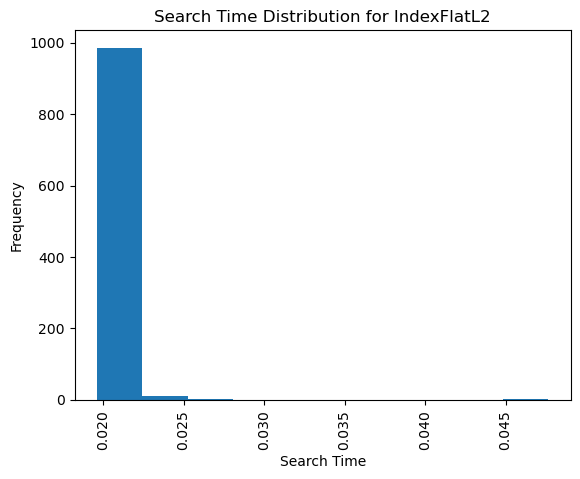

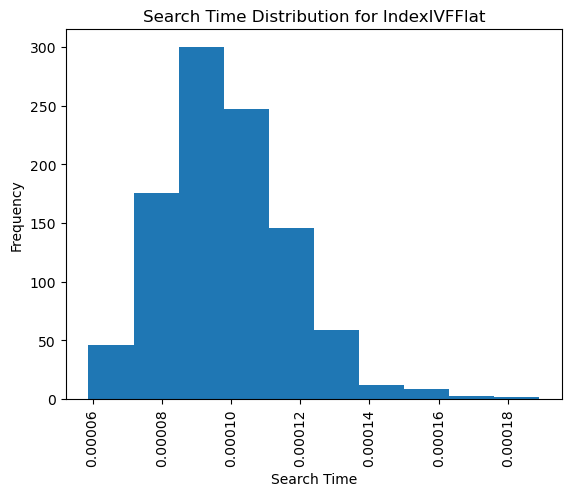

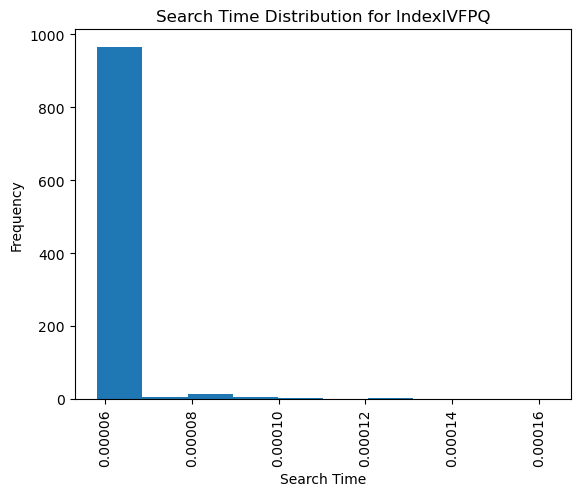

In [29]:
# Выборка случайной подвыборки из тестовых данных для измерения времени поиска
random_subset_test = test.sample(n=1000)
subset_test_embeddings = model.encode(random_subset_test.headline.to_numpy(), batch_size=64, show_progress_bar=True)

# Функция для измерения времени поиска и построения гистограммы
def measure_and_plot(index, query_embeddings, index_name):
    search_times = []
    for _ in range(len(query_embeddings)):
        start_time = time.perf_counter()  # Измерение времени с высокой точностью
        _ = measure_search_time(index, query_embeddings[_:_+1])
        end_time = time.perf_counter()  # Измерение времени с высокой точностью
        search_time = end_time - start_time
        search_times.append(search_time)

    plt.hist(search_times, bins=10)
    plt.title(f'Search Time Distribution for {index_name}')
    plt.xlabel('Search Time')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Создание индексов
index_FlatL2 = build_IndexFlatL2(headline_train_embeddings)
index_IVFFlat = build_IndexIVFFlat(headline_train_embeddings, int(np.sqrt(len(train))))
index_IVFPQ = build_IndexIVFPQ(headline_train_embeddings, int(np.sqrt(len(train))), m=8, bits=8)

# Измерение и построение гистограмм
measure_and_plot(index_FlatL2, subset_test_embeddings, 'IndexFlatL2')
measure_and_plot(index_IVFFlat, subset_test_embeddings, 'IndexIVFFlat')
measure_and_plot(index_IVFPQ, subset_test_embeddings, 'IndexIVFPQ')

## Задание 3

Возьмите построенные в задании 1 эмбеддинги краткого содержания новостей и сделайте **IndexIVFPQ** с теми же параметрами, как в задании 2, но только по краткому содержанию новостей.

In [33]:
# Параметры для построения IndexIVFPQ
nlist = int(np.sqrt(len(train)))  # Количество ячеек (аналогично заданию 2)
m = 8  # Параметр m для IndexIVFPQ
bits = 8  # Количество битов (bits) для IndexIVFPQ

# Создание индекса IndexIVFPQ
quantizer = faiss.IndexFlatL2(short_description_embeddings.shape[1])
index_IVFPQ = faiss.IndexIVFPQ(quantizer, short_description_embeddings.shape[1], nlist, m, bits)
index_IVFPQ.train(short_description_embeddings)
index_IVFPQ.add(short_description_embeddings)

## Задание 4

Возьмите из группы test по 100 строк из каждой тематики новостей. Далее, если будете искать в индексе по заголовкам (как в задании 2), используйте заголовок новости, если будете искать в индексе по краткому содержанию (задание 3), то используйте краткое содержание.

**Вопрос**: Как много среди ближайших соседей в индексе новостей С ТОЙ ЖЕ ТЕМАТИКОЙ?

**Как на него ответить**: Разберем на примере COMEDY. Вы взяли 100 текстов из группы test с темой COMEDY. Сгенерируйте их эмбеддинги и для каждой из новостей найдите 10 ближайших соседей в индексе по заголовкам и в индексе по краткому содержанию. По полученным ближайшим соседям посчитайте, у скольких из соседей тема ТОЖЕ COMEDY.
Так вы получите 100 чисел для индекса по заголовкам и 100 чисел для индекса по краткому содержанию. 

Ответом будут 2 гистограммы для каждой из тематик. 
Понятно ли, почему гистограммы вышли именно такие как вышли?

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [08:30<00:00, 12.15s/it]


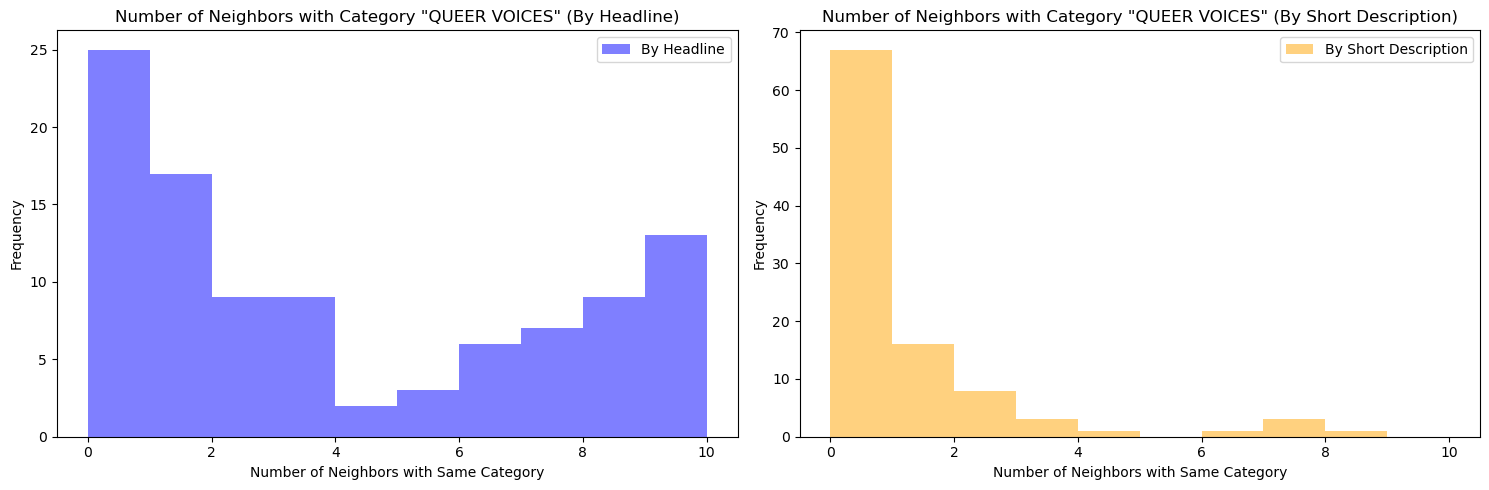

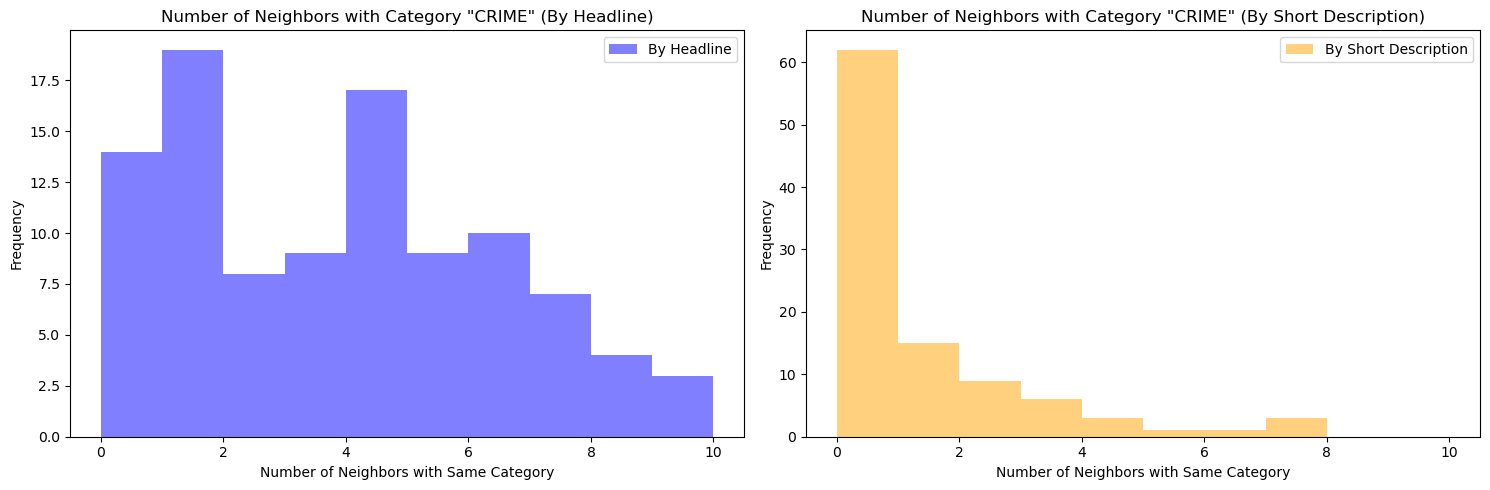

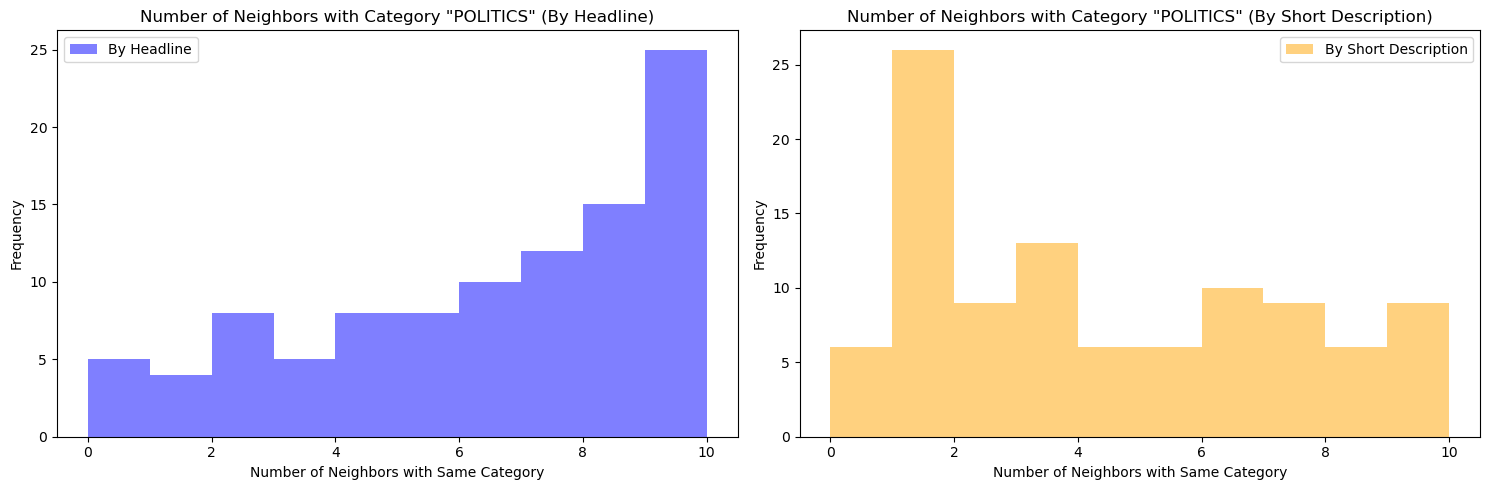

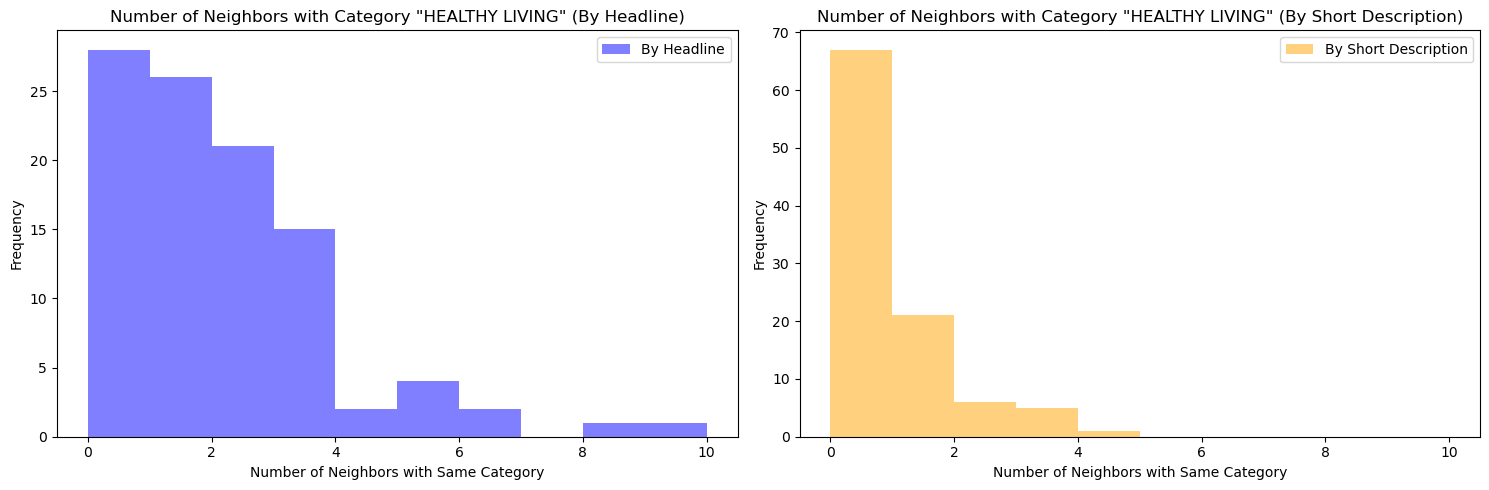

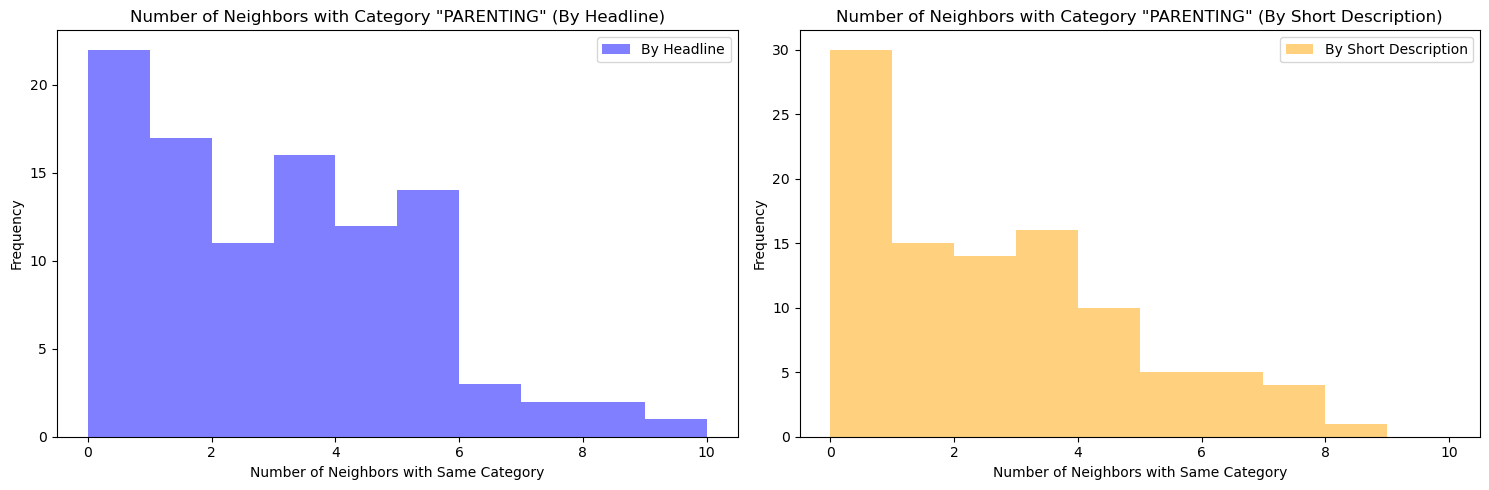

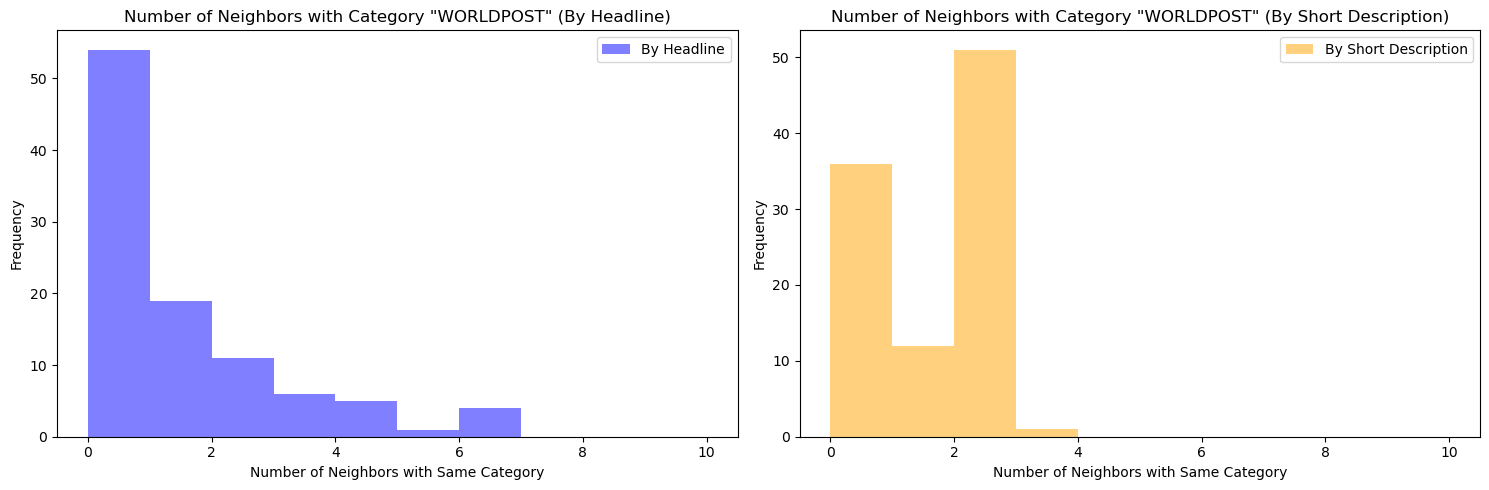

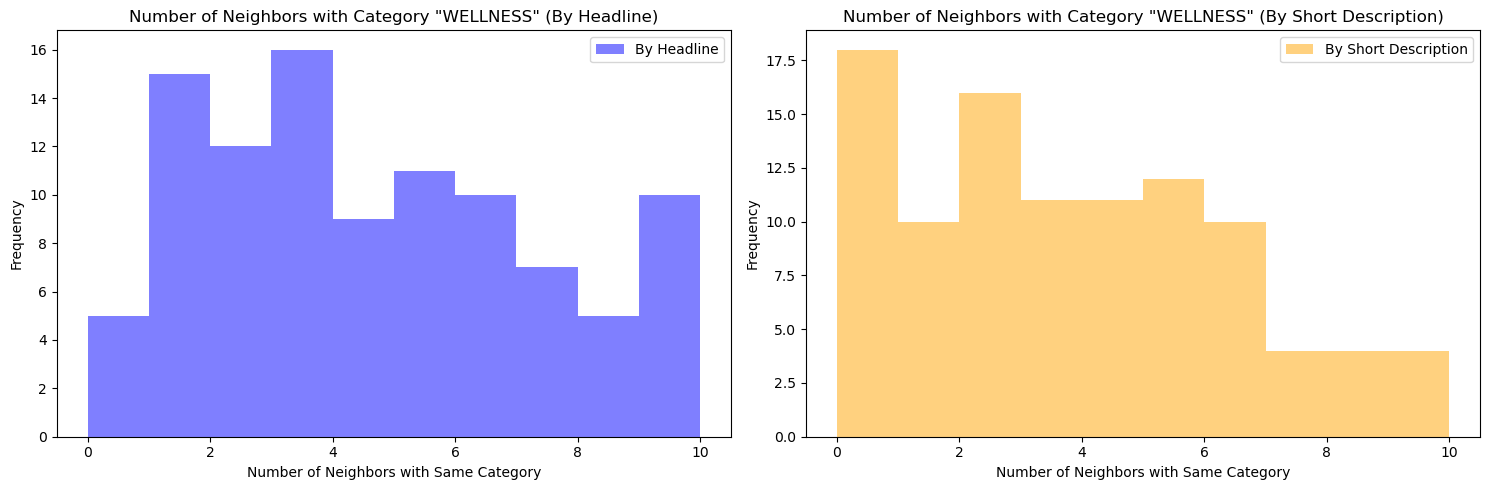

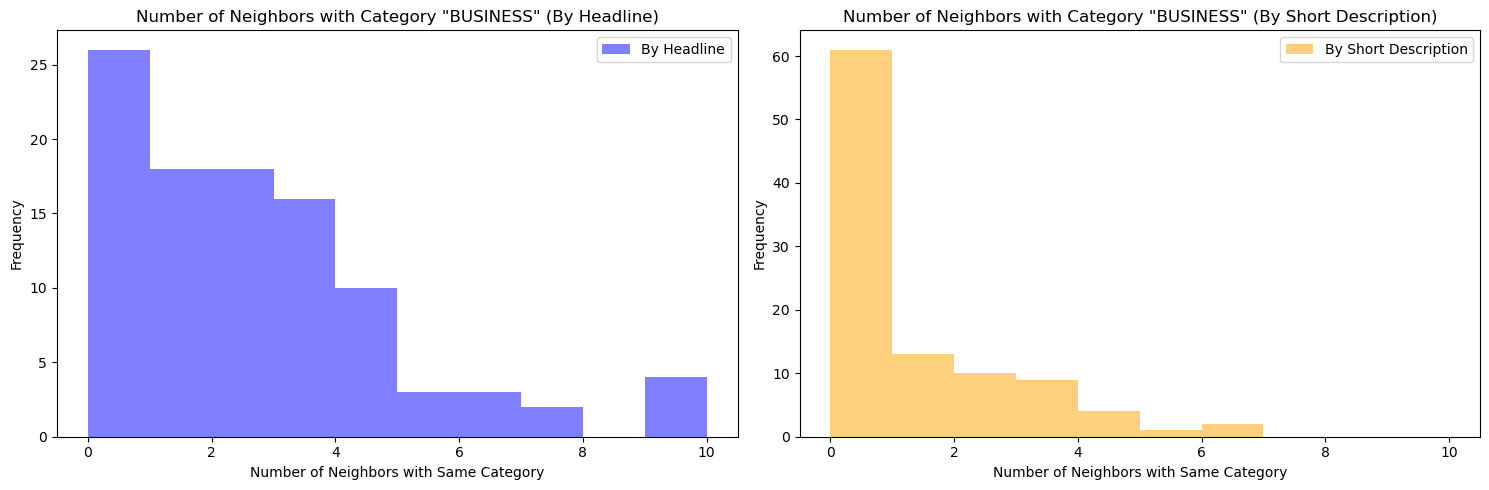

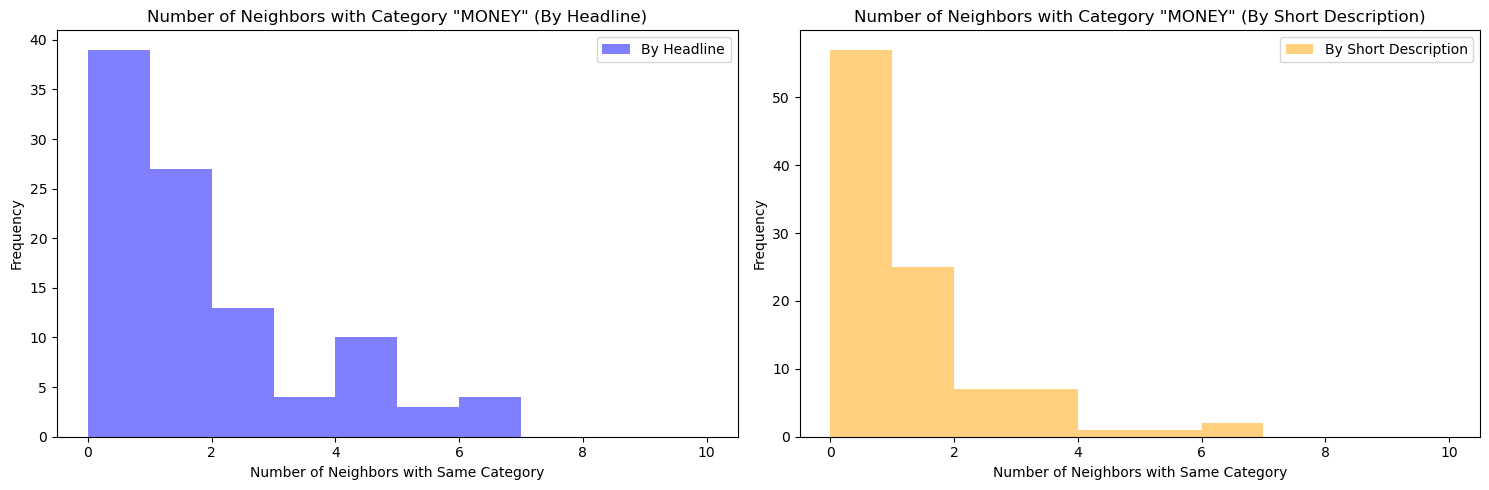

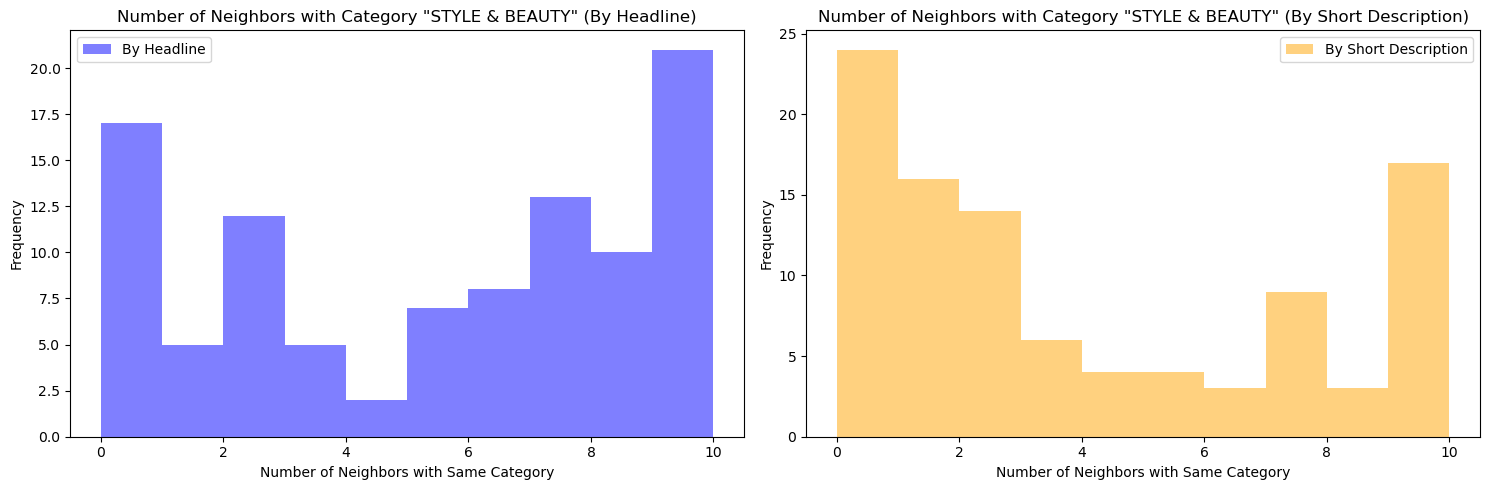

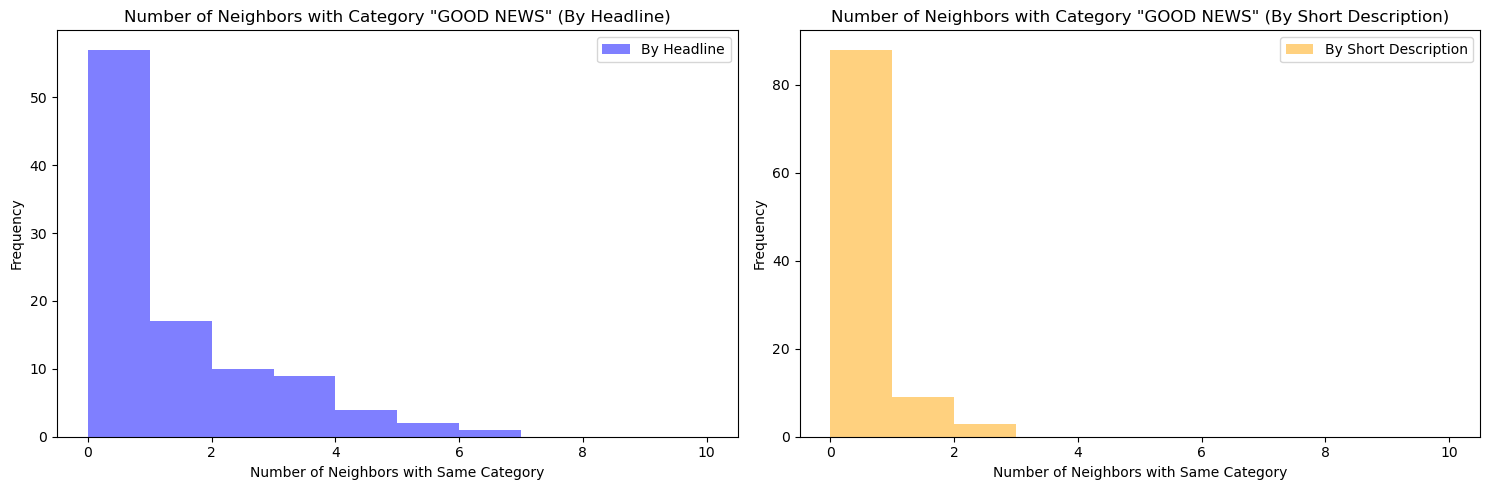

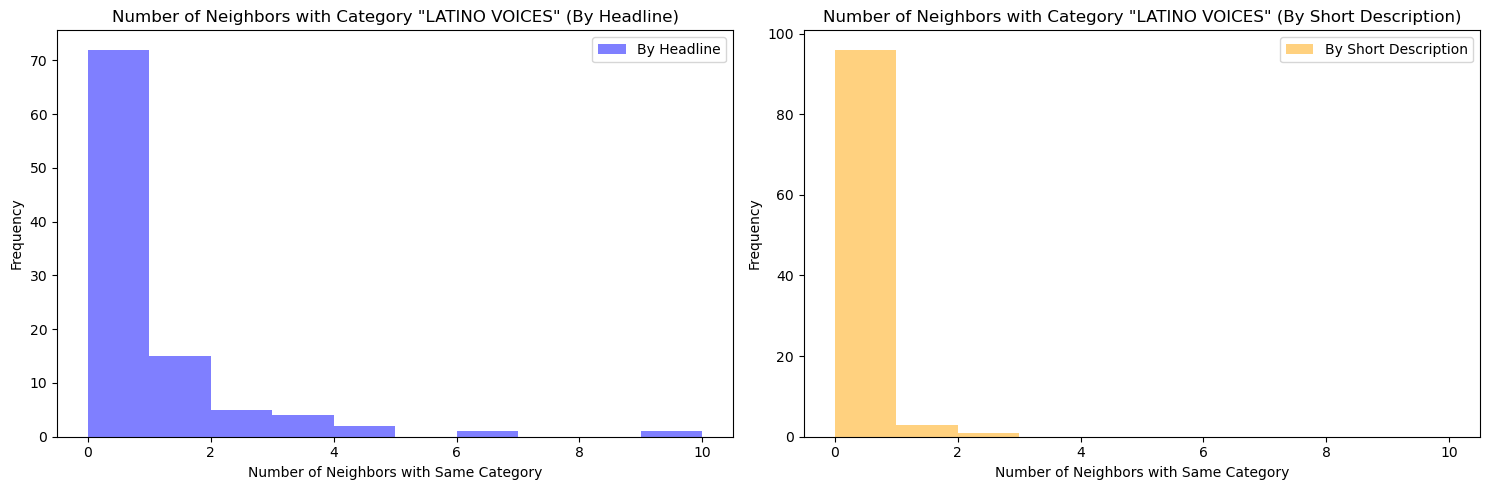

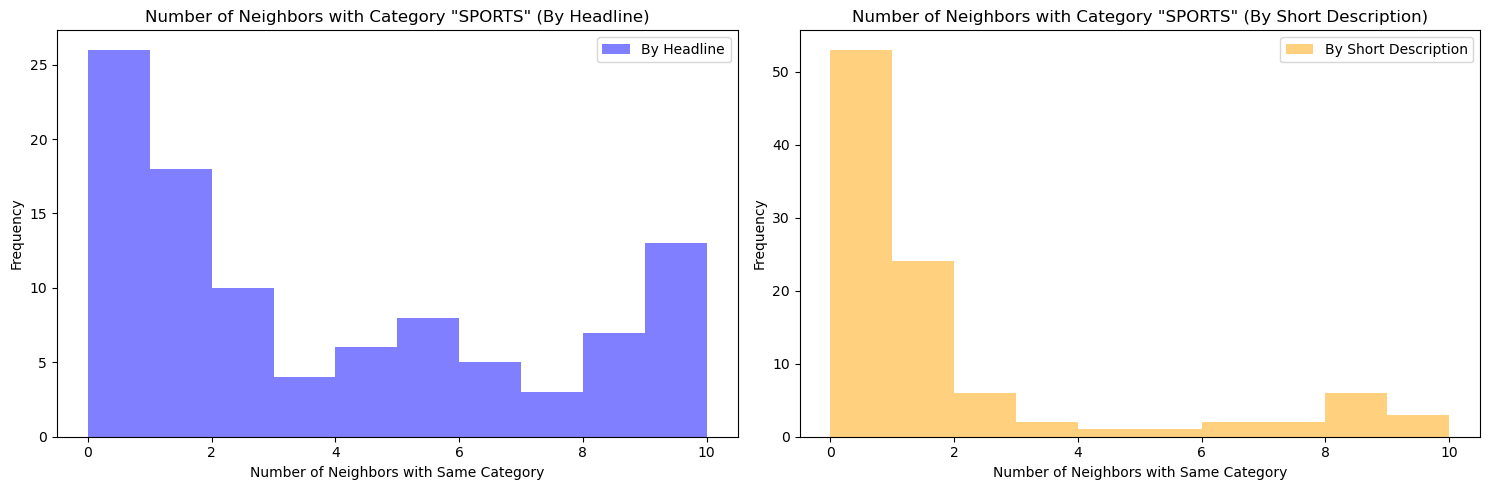

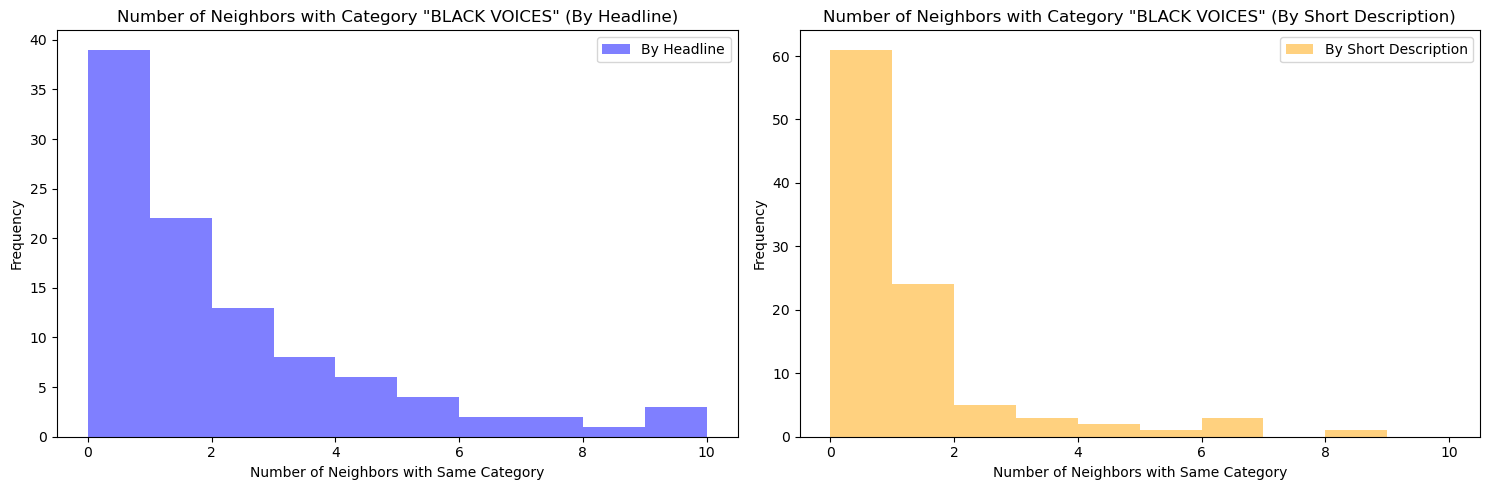

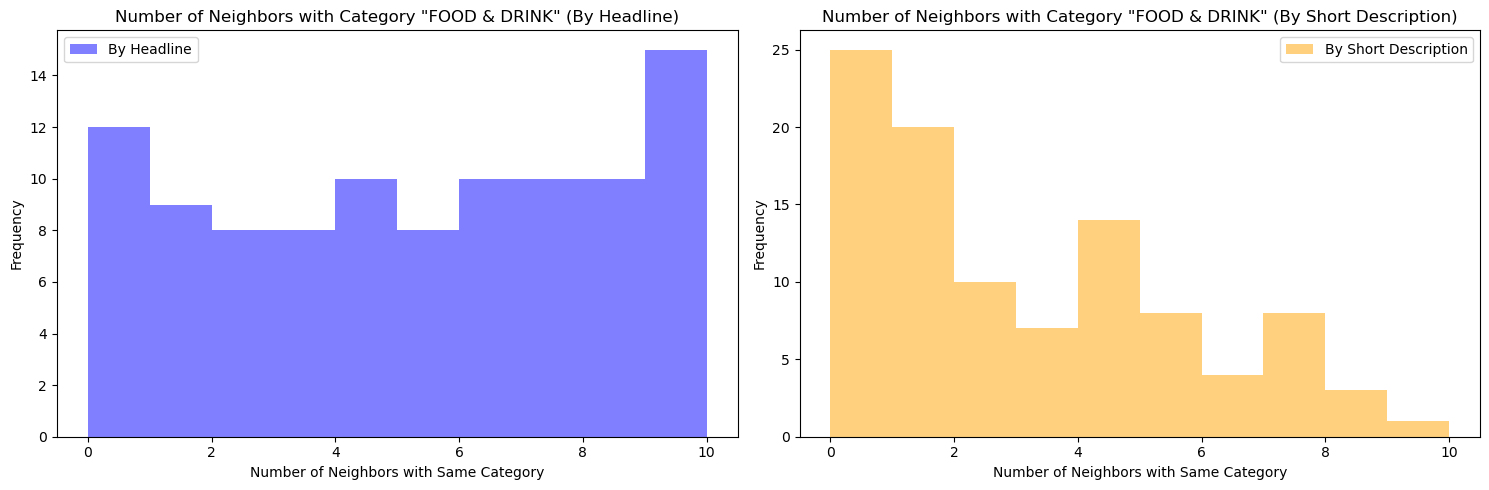

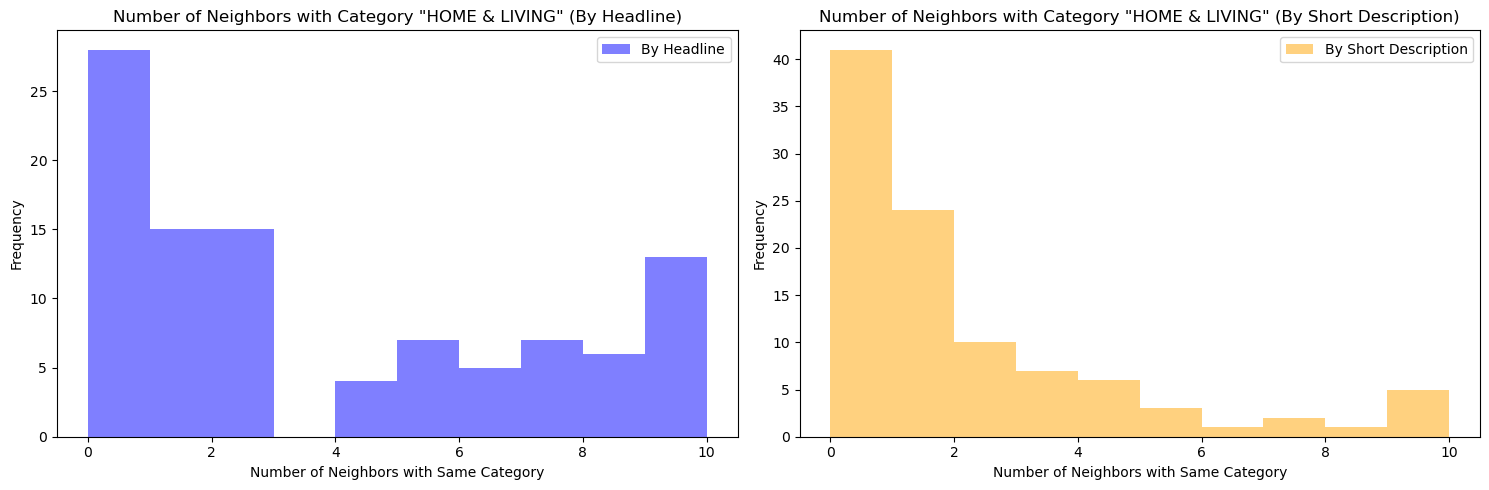

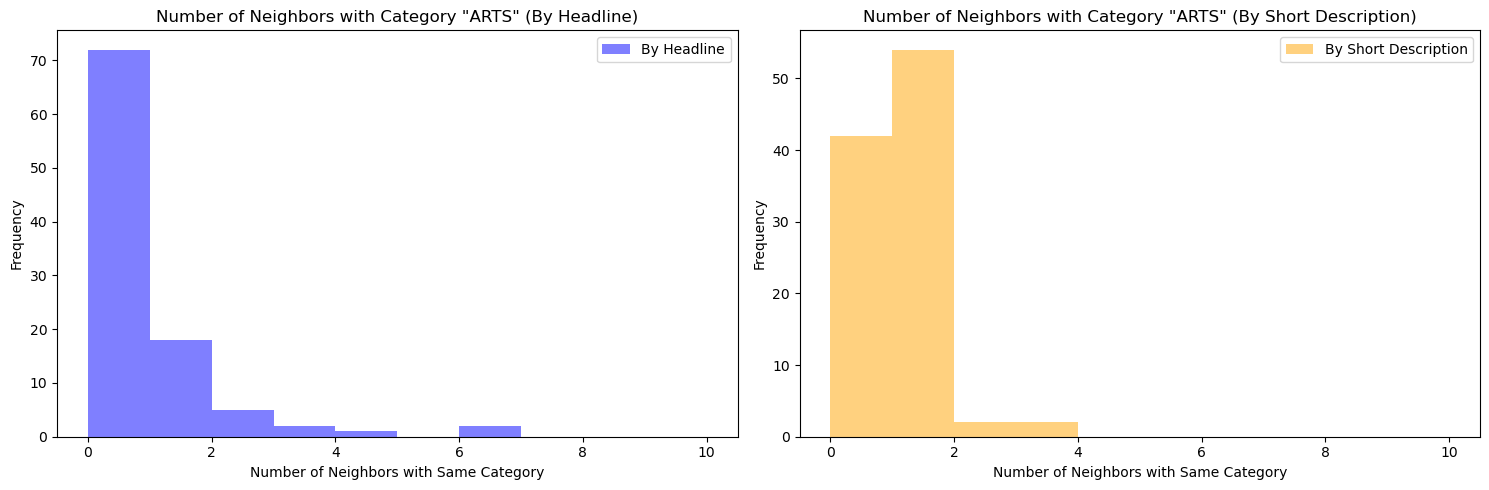

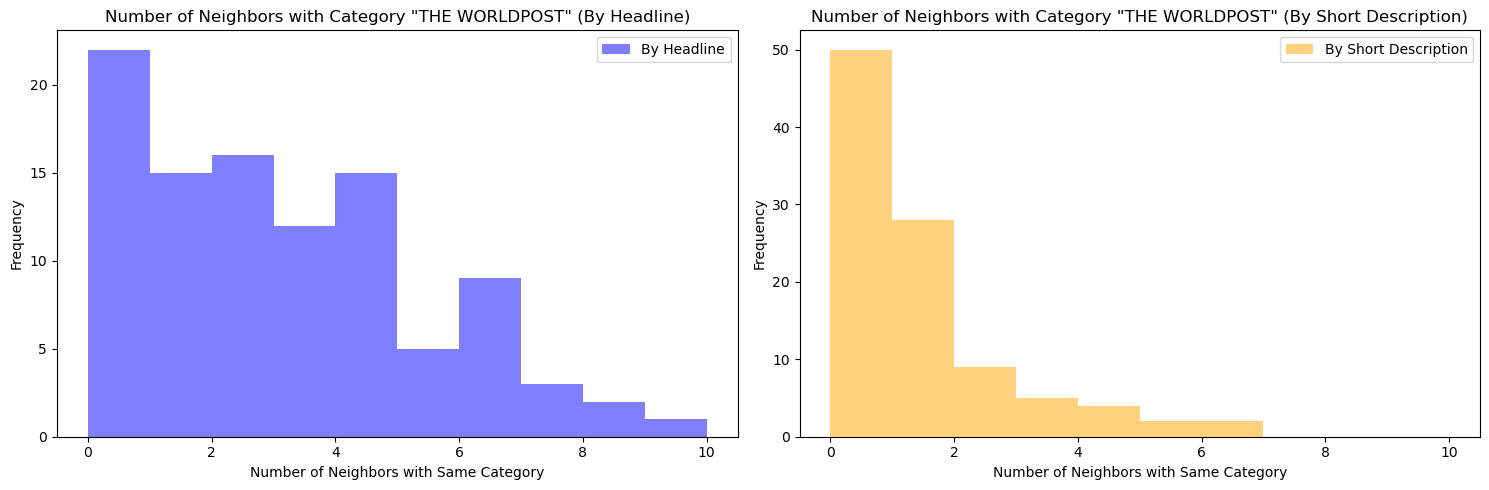

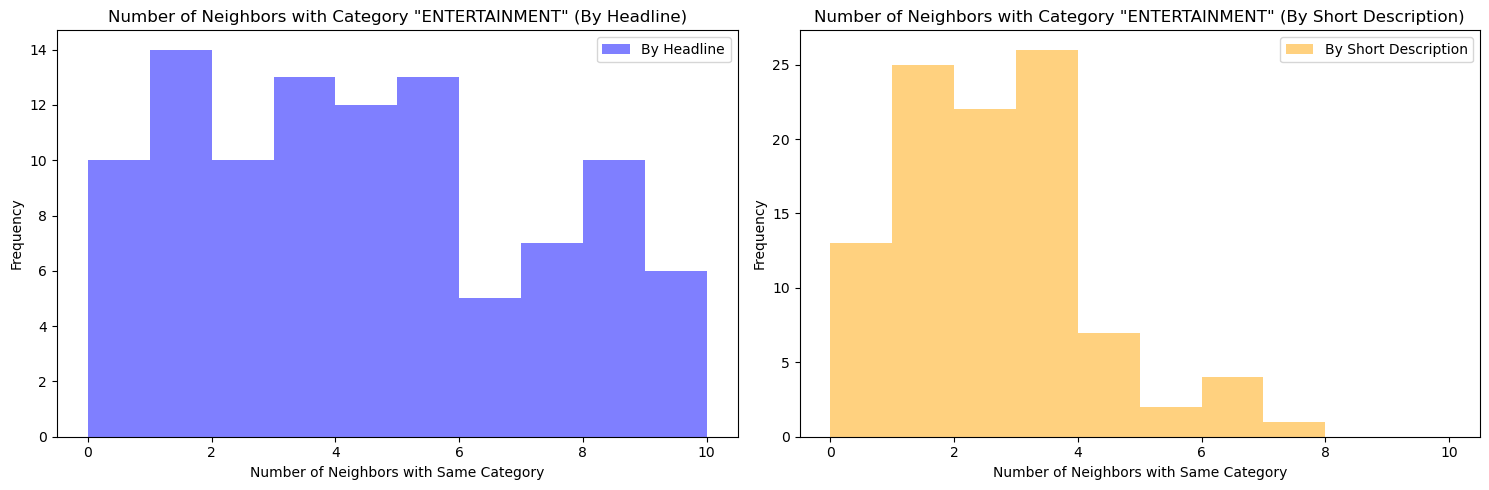

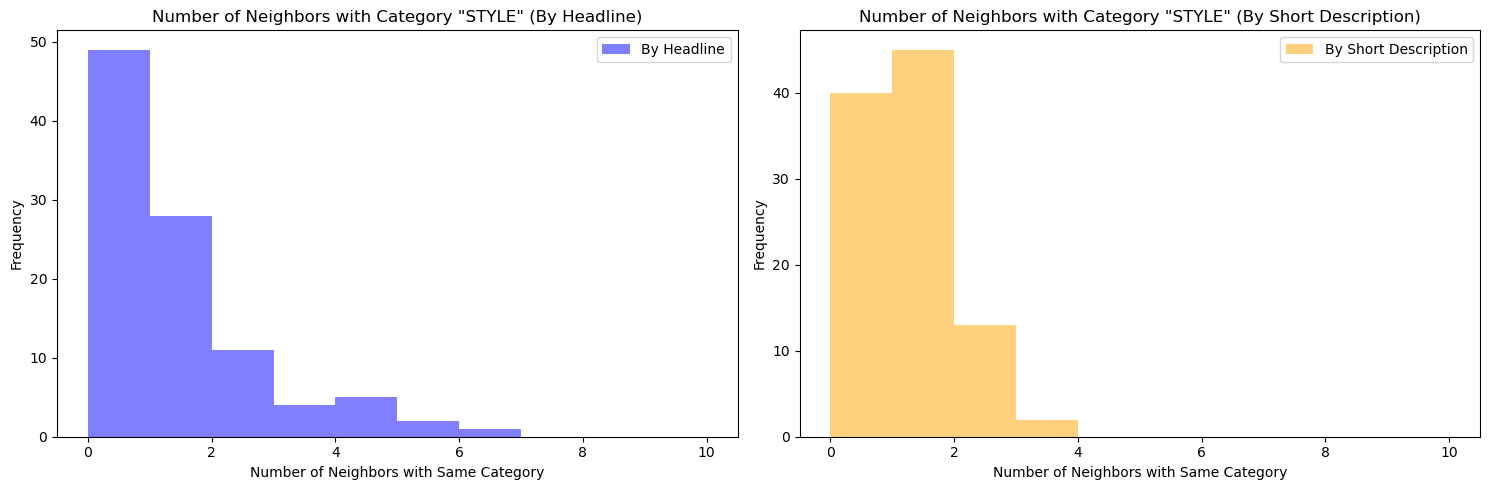

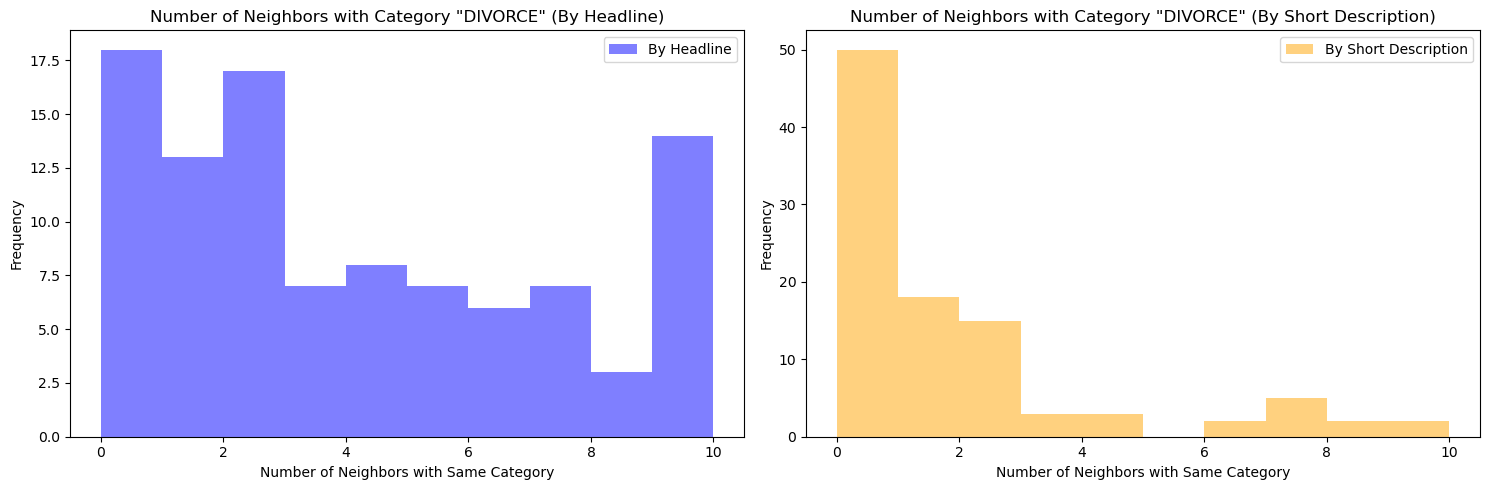

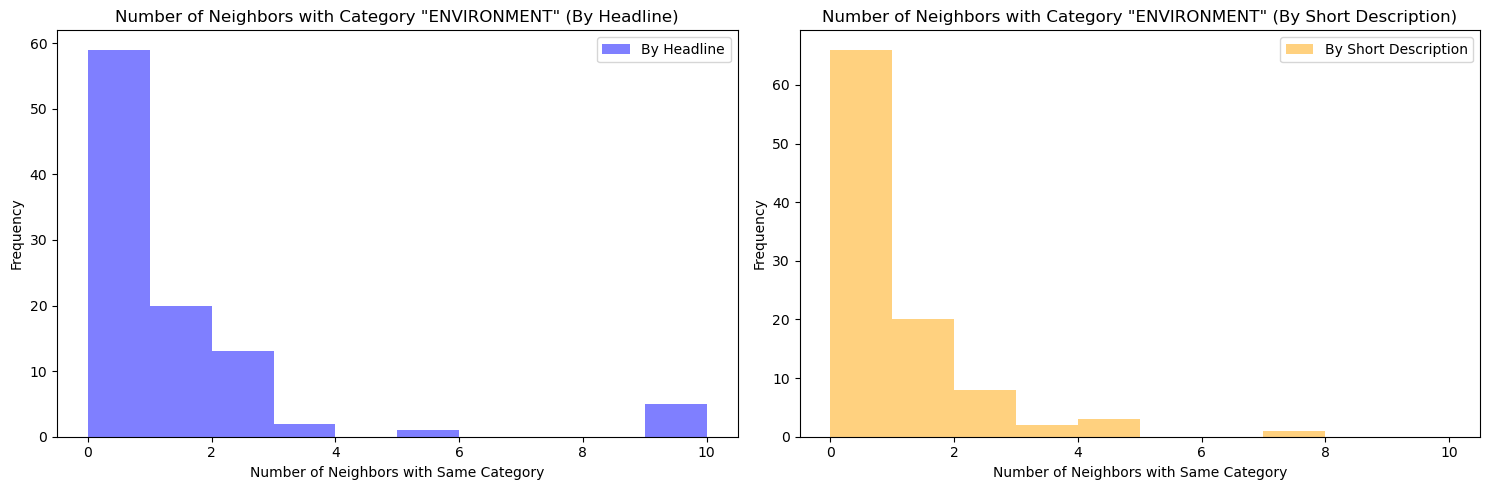

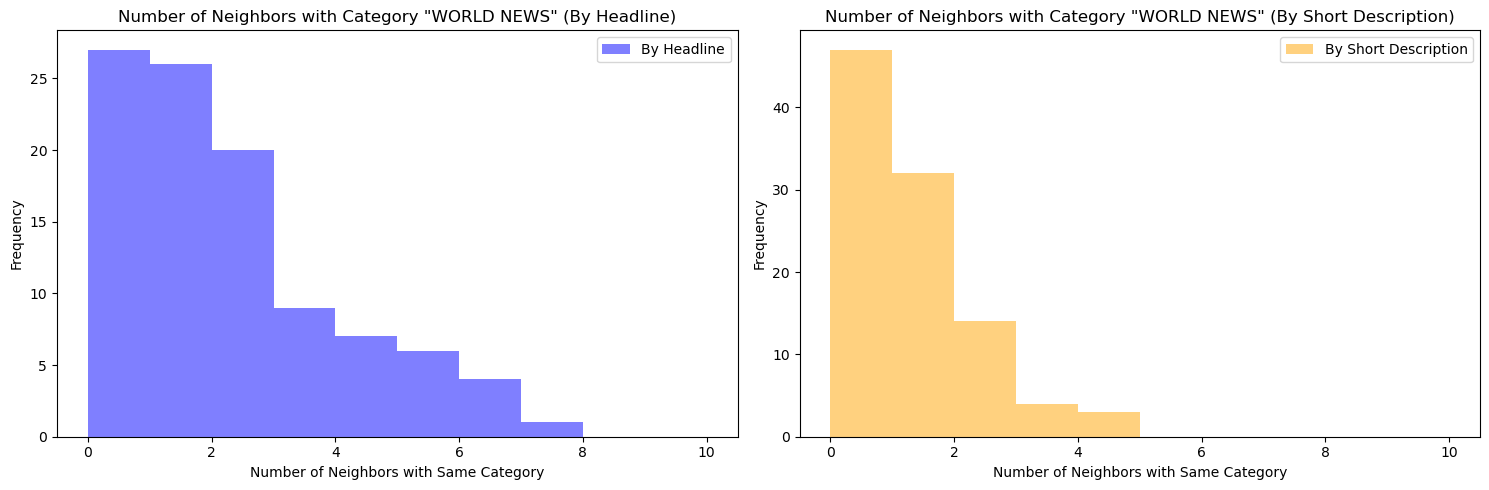

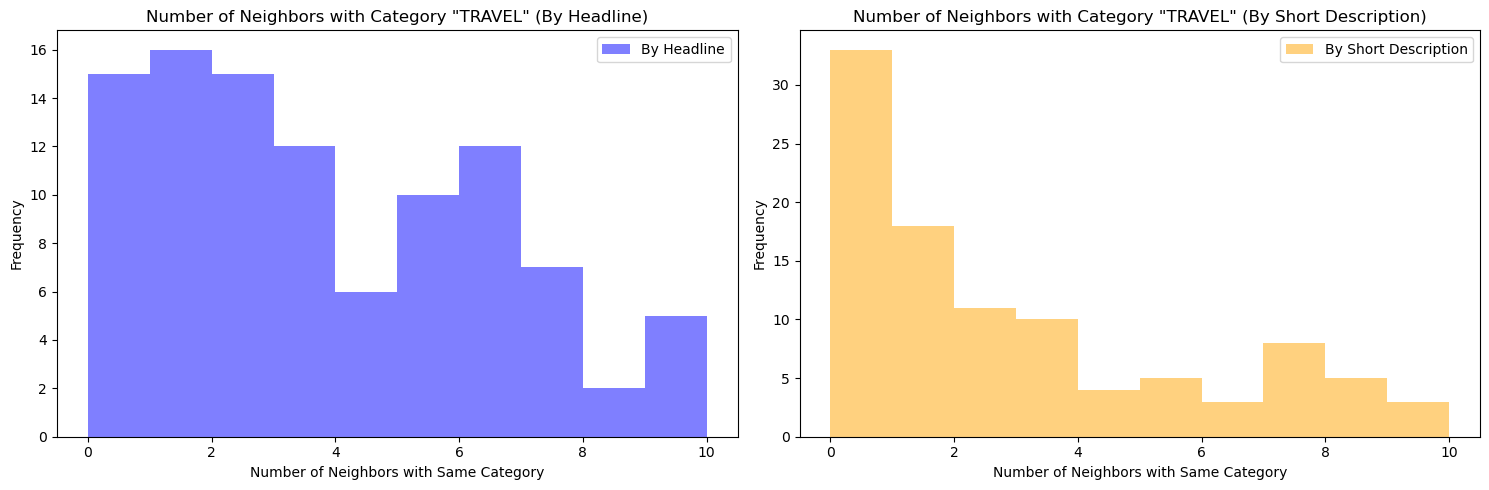

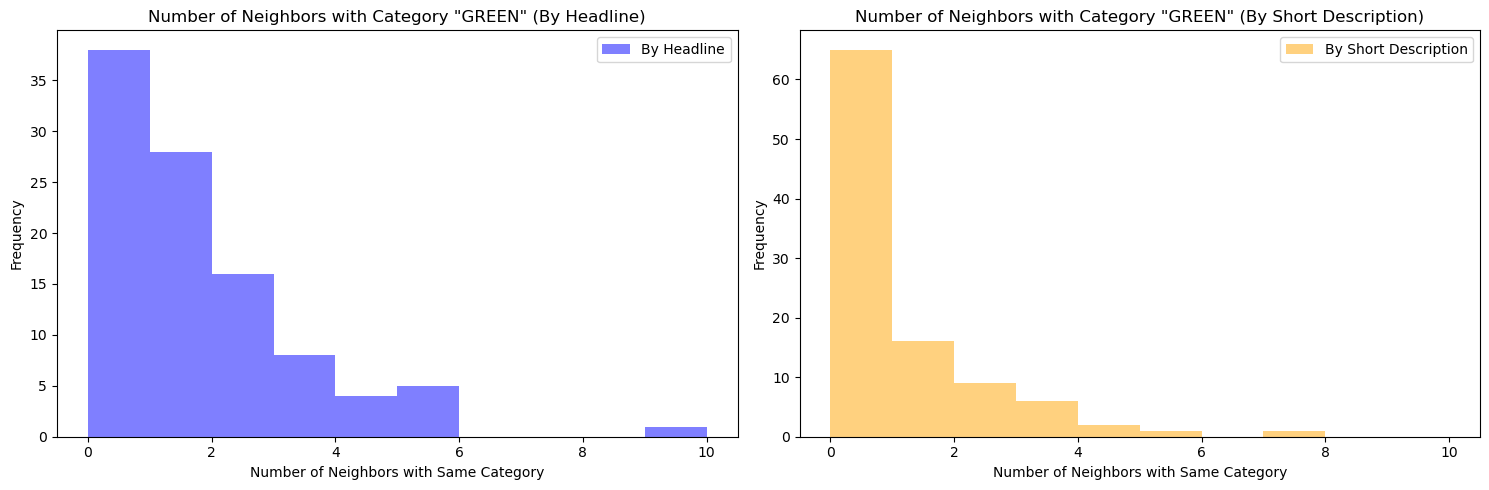

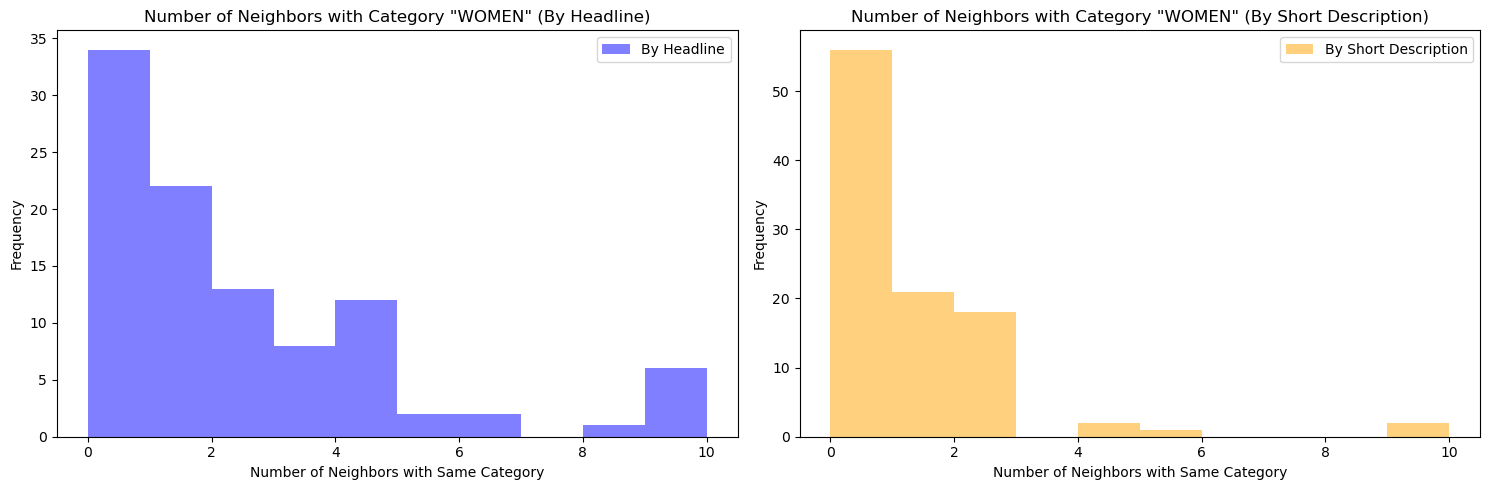

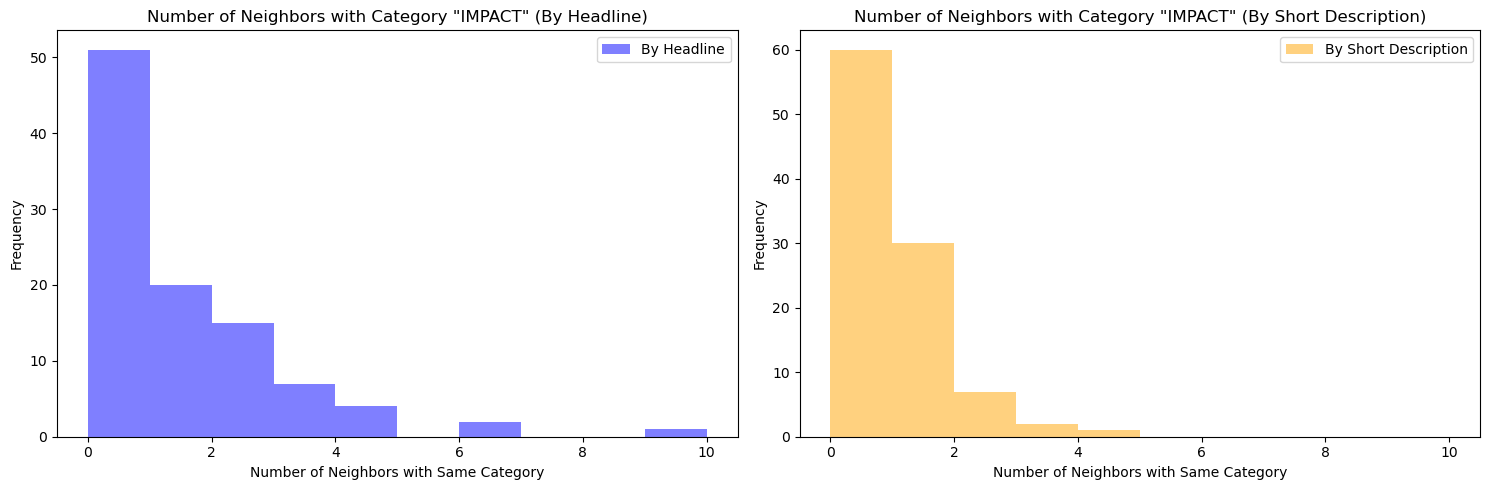

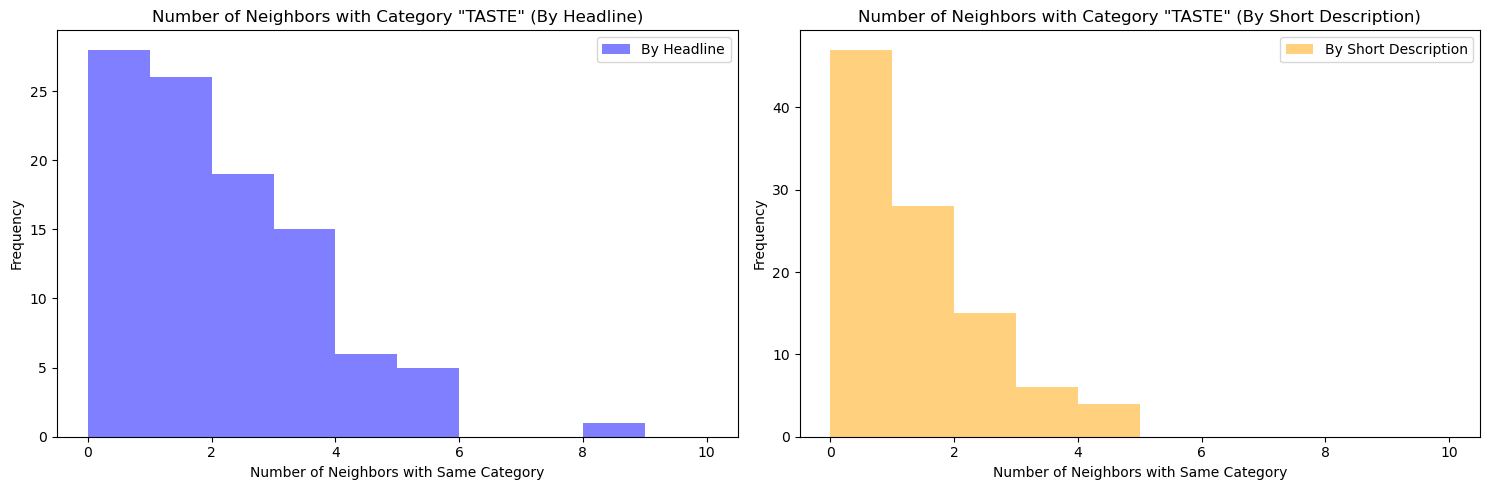

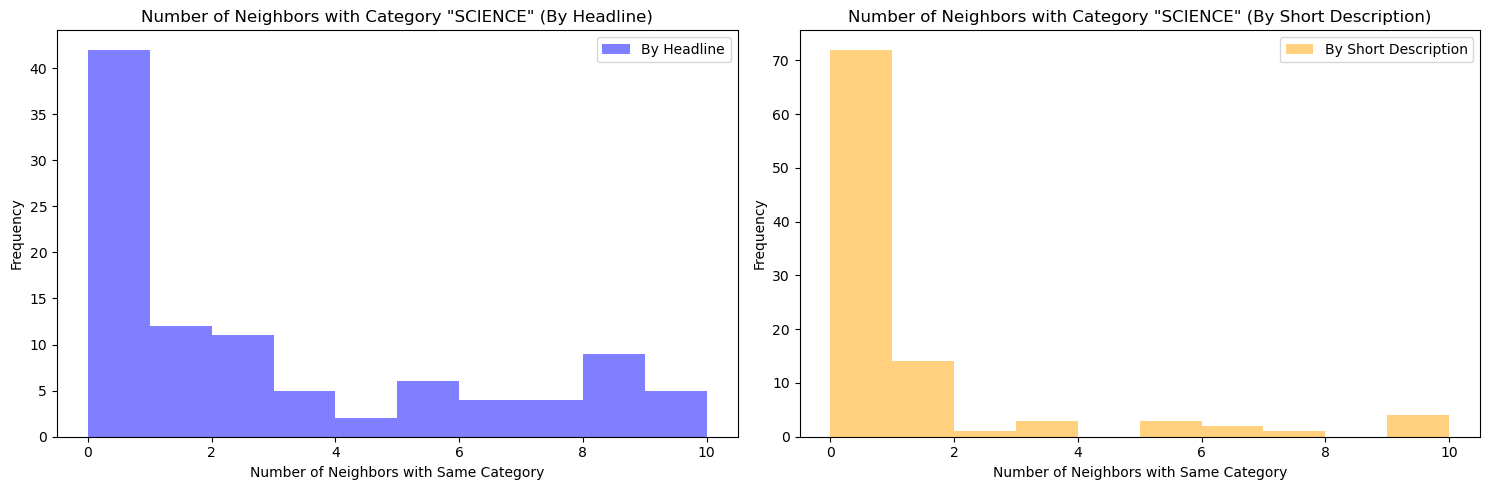

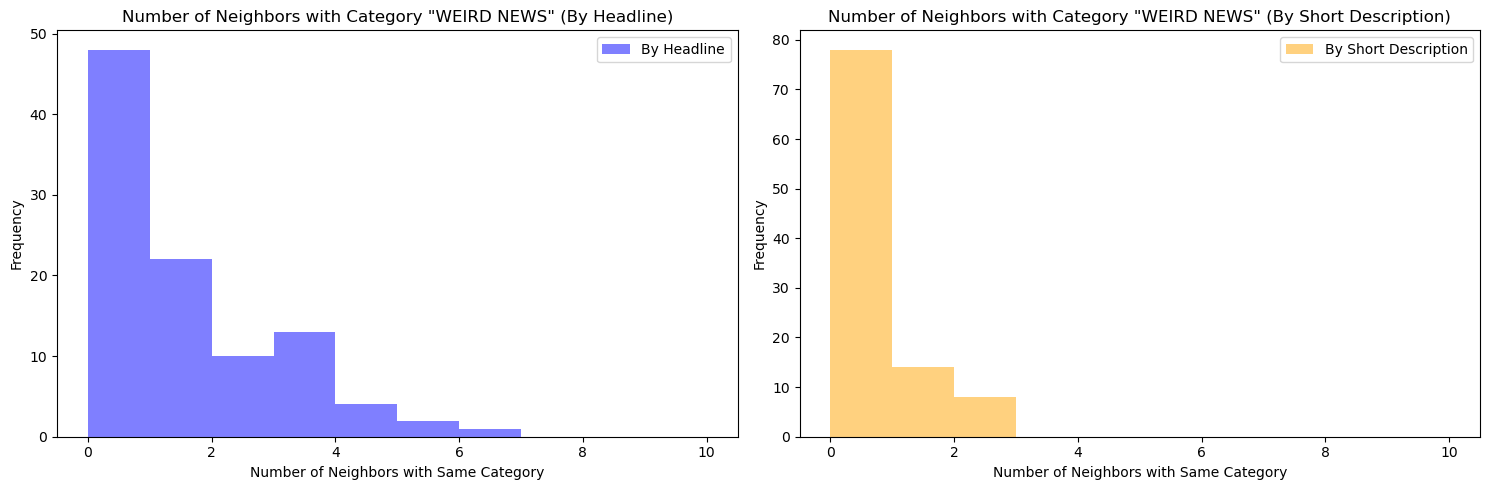

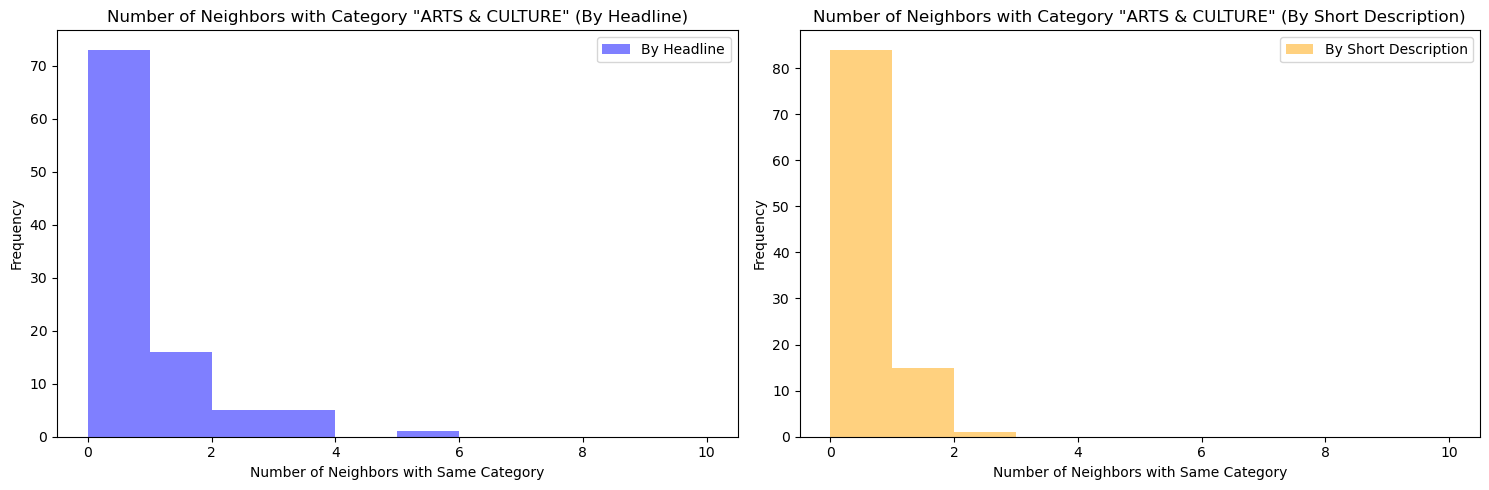

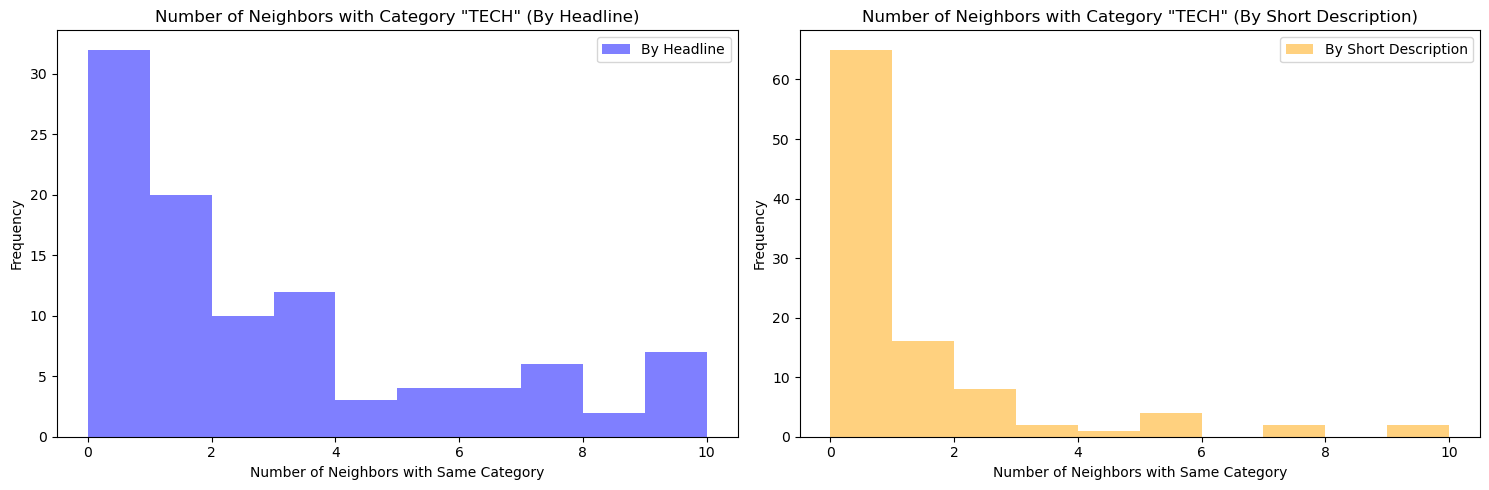

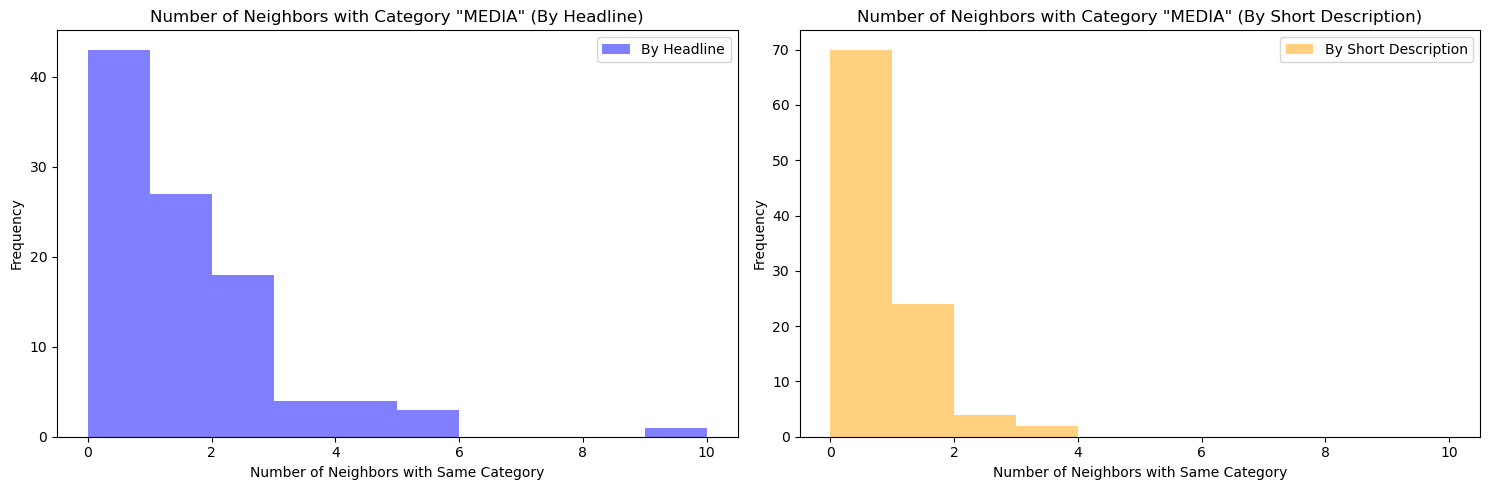

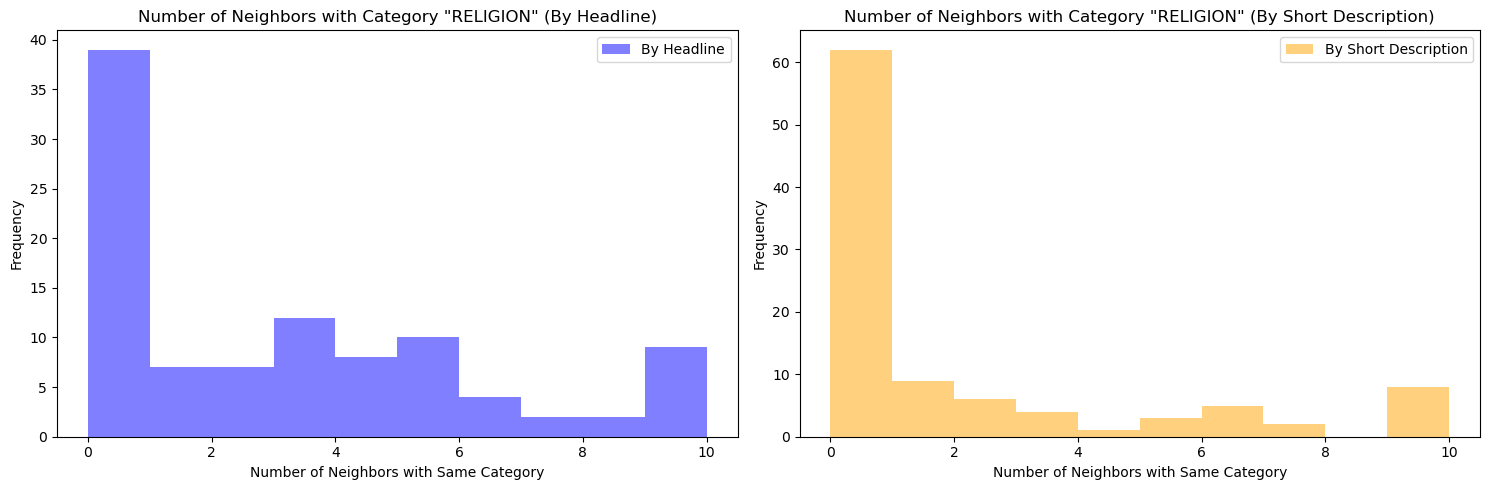

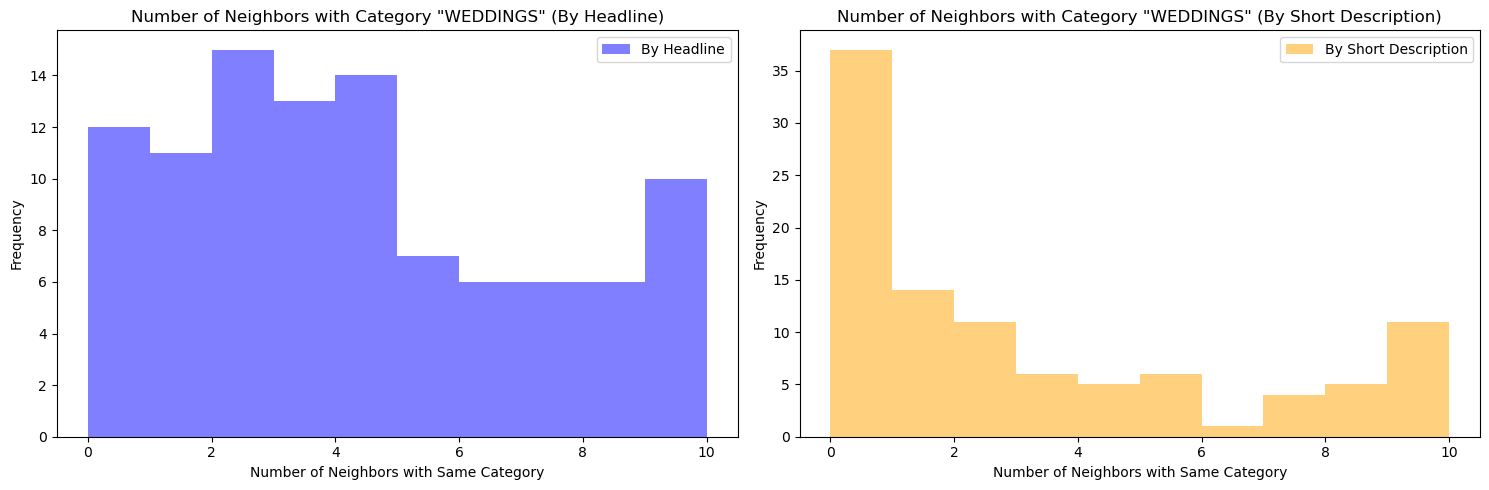

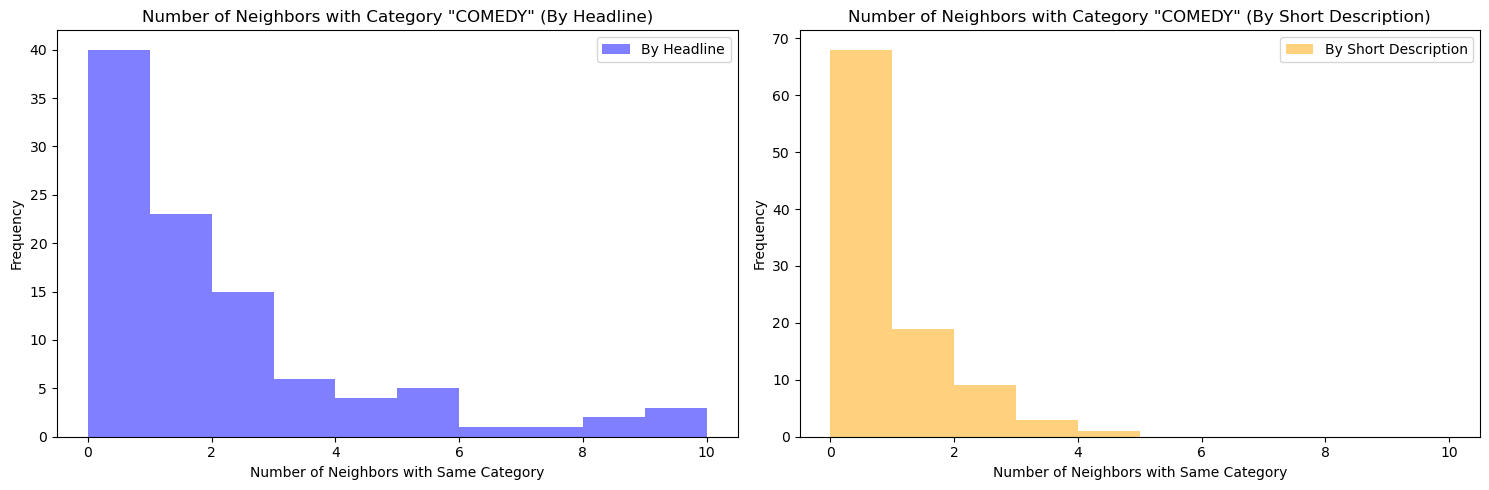

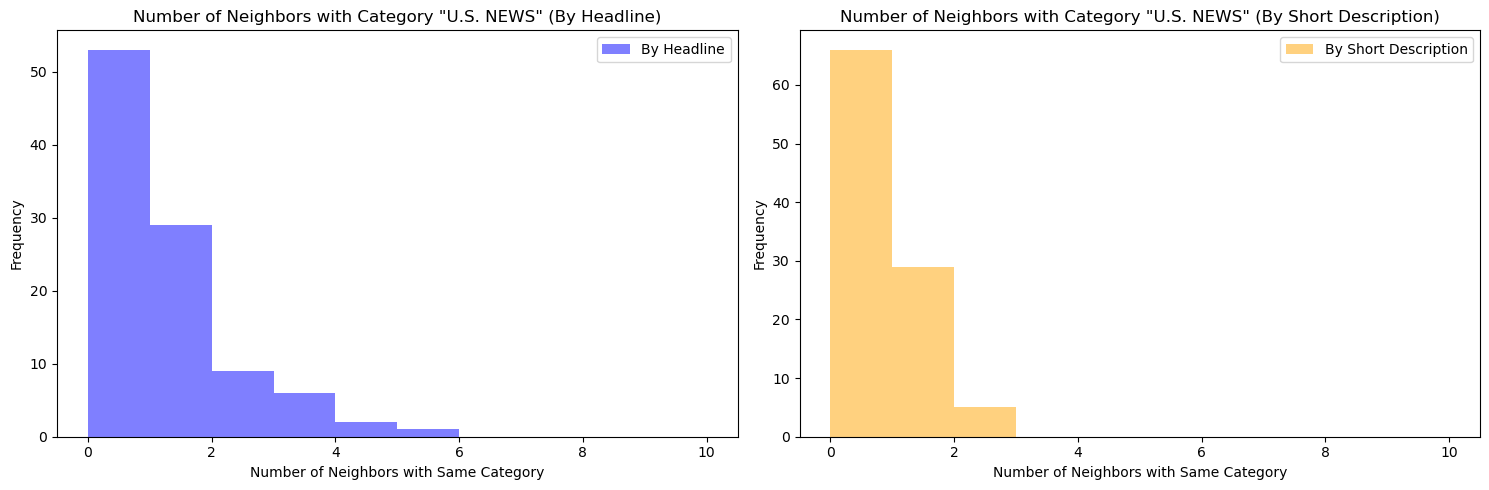

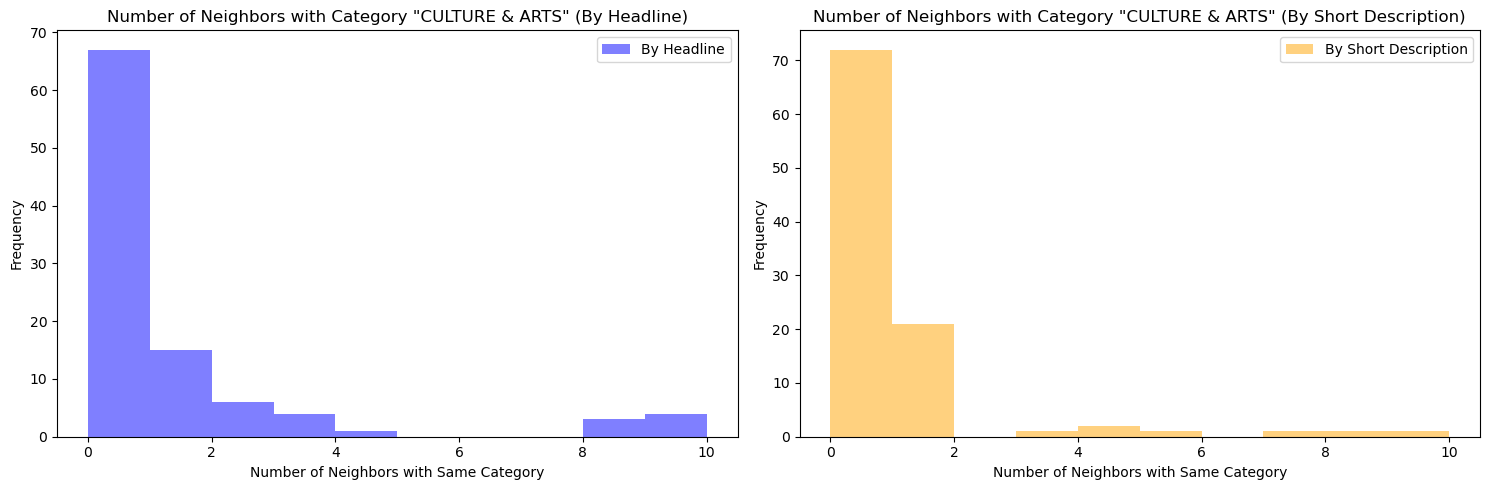

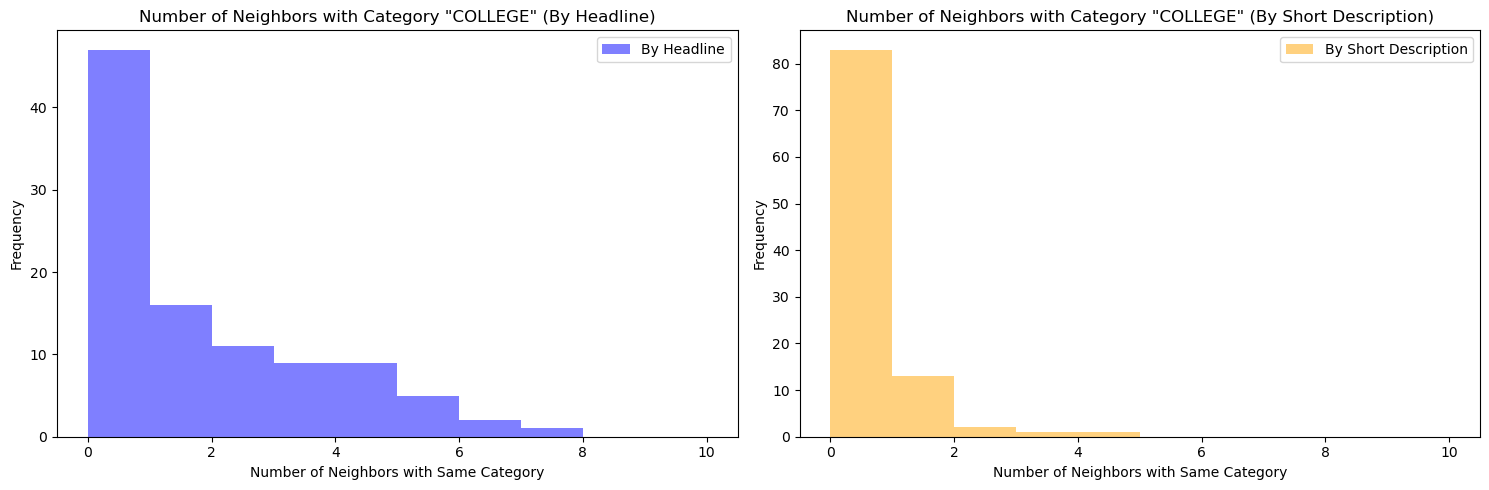

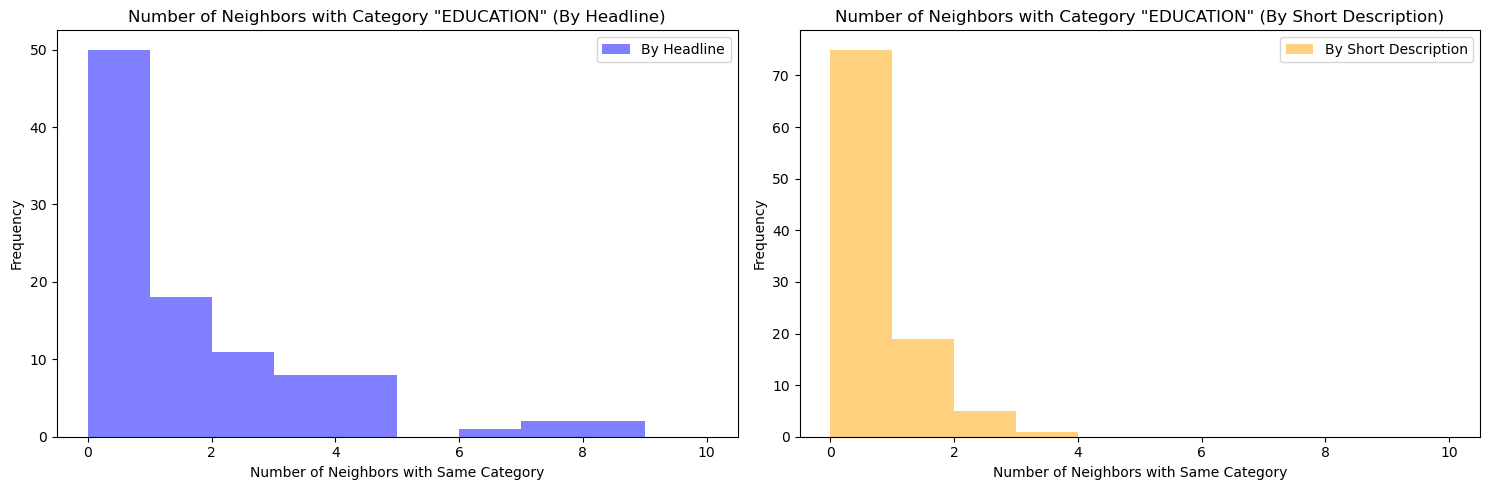

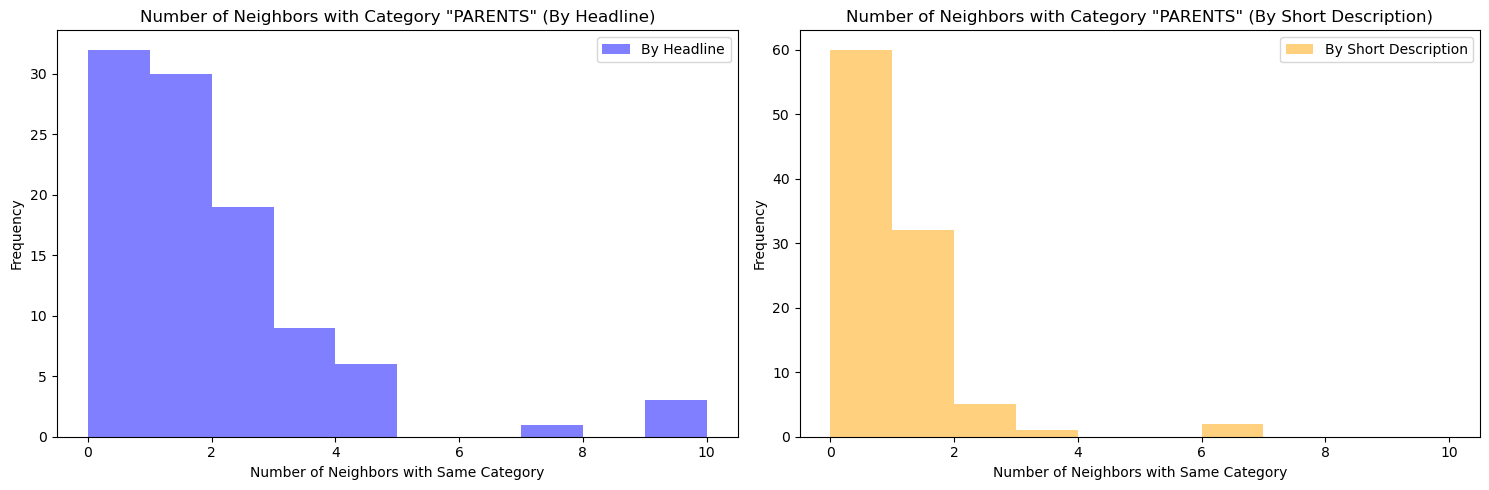

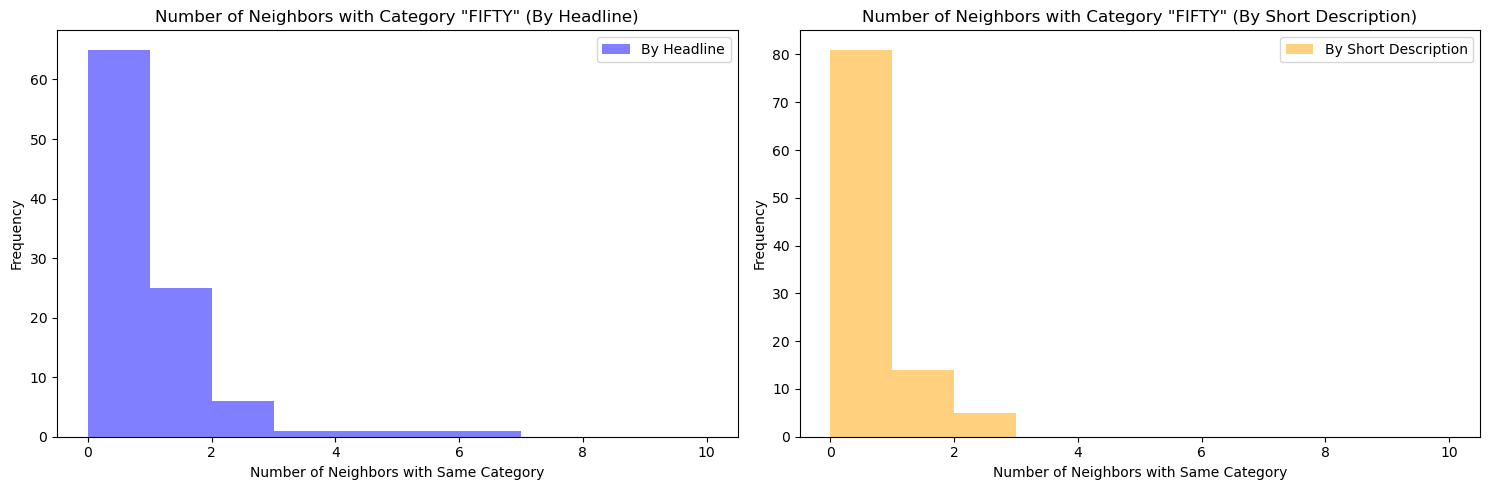

In [60]:
def find_similar_neighbors(index, embeddings, category, query_embeddings):
    similar_neighbors = []
    for query_emb in query_embeddings:
        D, I = index.search(query_emb.reshape(1, -1), 11)  # Находим 11 ближайших соседей, так как первым будет сам текст
        neighbors_categories = train.iloc[I[0][1:]]['category'].tolist()  # Исключаем первого соседа (сам текст)
        similar_neighbors.append(neighbors_categories.count(category))
    return similar_neighbors

categories = train["category"].unique()
num_texts_per_category = 100
similar_neighbors_headline = {category: [] for category in categories}
similar_neighbors_short_description = {category: [] for category in categories}

for category in tqdm(categories):
    # Выбираем 100 текстов из каждой категории в тестовой выборке
    subset_test_category = test[test['category'] == category].sample(n=num_texts_per_category)
    query_embeddings_headline = model.encode(subset_test_category['headline'].to_numpy(), batch_size=64, show_progress_bar=False)
    query_embeddings_short_description = model.encode(subset_test_category['short_description'].to_numpy(), batch_size=64, show_progress_bar=False)
    
    # Ищем ближайших соседей для каждой новости по заголовкам и кратким описаниям
    similar_neighbors_headline[category] = find_similar_neighbors(index_FlatL2, headline_train_embeddings, category, query_embeddings_headline)
    similar_neighbors_short_description[category] = find_similar_neighbors(index_IVFPQ, short_description_embeddings, category, query_embeddings_short_description)

# Построение гистограмм для каждой категории
for category in categories:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.hist(similar_neighbors_headline[category], bins=range(11), alpha=0.5, label='By Headline', color='blue')
    plt.title(f'Number of Neighbors with Category "{category}" (By Headline)')
    plt.xlabel('Number of Neighbors with Same Category')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(similar_neighbors_short_description[category], bins=range(11), alpha=0.5, label='By Short Description', color='orange')
    plt.title(f'Number of Neighbors with Category "{category}" (By Short Description)')
    plt.xlabel('Number of Neighbors with Same Category')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()


В целом, результат не удивительный, доля ключевых слов, относящих статью к определенной теме, выше у заголовков, чем у коротких описаний - отсюда такой итог.


## Задание 5

Поработайте асессором. Возьмите наиболее интересную для вас тему из группы test (например из предыдущего задания). Сохраните 5 ближайших соседей для каждого из этих запросов (прямо тексты возьмите). У вас получится датафрейм вида:

    Запрос 1 -> Сосед 1
    Запрос 1 -> Сосед 2
    Запрос 1 -> Сосед 3
    ...
    Запрос 100 -> Сосед 4
    Запрос 100 -> Сосед 5

Всего строк будет 500 (это не особо много, можно просмотреть глазами). Просмотрите получившиеся данные и для каждой строки проставьте "схожа тема у запроса и его найденного соседа или нет" (да, прямо глазами). Вы получите датафрейм вида:  

    Запрос 1 -> Сосед 1 -> Близко
    Запрос 1 -> Сосед 2 -> Близко
    Запрос 1 -> Сосед 3 -> Не близко
    ...
    Запрос 100 -> Сосед 4 -> Не близко
    Запрос 100 -> Сосед 5 -> Близко
    
    
Если считать, что "Близко" это 1, а "не близко" это 0, посчитайте, сколько в среднем у запроса среди ближайших соседей ответов, которые "не близко", без оглядки на то, какая у низ проставлена тема в поле category.

In [74]:
query_category = 'COMEDY'  # Выбираем тему запросов
num_queries = 100  # Количество запросов

# Выбираем 100 случайных текстов с темой 'COMEDY' из тестовой выборки
queries = test[test['category'] == query_category].sample(n=num_queries)['headline'].tolist()

# Создаем список для хранения соседей каждого запроса
neighbors = []

for query in queries:
    query_embedding = model.encode([query])[0]  # Получаем эмбеддинг запроса
    D, I = index_FlatL2.search(np.array([query_embedding]), 6)  # Находим 5 ближайших соседей (+ сам текст)

    # Сохраняем тексты соседей, исключая первого соседа (сам текст)
    query_neighbors = train.iloc[I[0][1:]]['headline'].tolist()
    neighbors.extend([(query, neighbor) for neighbor in query_neighbors])

# Создаем DataFrame с запросами и их соседями
result_frame = pd.DataFrame(neighbors, columns=['Query', 'Neighbor'])

# Спрашиваем пользователя о схожести тематик запросов и их соседей
result_frame['Similarity'] = result_frame.apply(lambda row: input("Схожа ли тема запроса " + row['Query'] + " и его соседа " + row['Neighbor'] + " (1 - да, 0 - нет): "), axis=1)
result_frame['Similarity'] = result_frame['Similarity'].astype(int)  # Преобразуем ответы в числовой формат

# Создаем новый датафрейм, вычисляя среднее для каждого запроса
mean_similarity = result_frame.groupby('Query')['Similarity'].mean().reset_index()
mean_similarity.columns = ['Query', 'Mean_Similarity']

Схожа ли тема запроса Stephen Colbert And John Oliver Give Democrats' 'Fight Song' The Makeover It Really Needs и его соседа Bernie Sanders And Allies Aim To Shape Democrats’ Agenda After Primaries (1 - да, 0 - нет): 1
Схожа ли тема запроса Stephen Colbert And John Oliver Give Democrats' 'Fight Song' The Makeover It Really Needs и его соседа Paul Ryan: Republicans Need To 'Pay Attention' To Democrats' Big Special Election Win (1 - да, 0 - нет): 1
Схожа ли тема запроса Stephen Colbert And John Oliver Give Democrats' 'Fight Song' The Makeover It Really Needs и его соседа Governor Charged With Helping Democrats Win Says Primary Fights Are Good For The Party (1 - да, 0 - нет): 1
Схожа ли тема запроса Stephen Colbert And John Oliver Give Democrats' 'Fight Song' The Makeover It Really Needs и его соседа Congressional Democrats Tell DOJ To Do More To Address COVID-19 Hate Crimes (1 - да, 0 - нет): 1
Схожа ли тема запроса Stephen Colbert And John Oliver Give Democrats' 'Fight Song' The Makeove

Схожа ли тема запроса John Oliver & His Celebrity Friends Create The Perfect Sex Ed Video и его соседа Best Coworkers Ever Throw Beyoncé-Themed Shower For Friend's 'Bey-Beys' (1 - да, 0 - нет): 1
Схожа ли тема запроса John Oliver & His Celebrity Friends Create The Perfect Sex Ed Video и его соседа Taylor Schilling's 'The Overnight' Is The Refreshing Sex Comedy We Need (1 - да, 0 - нет): 1
Схожа ли тема запроса John Oliver & His Celebrity Friends Create The Perfect Sex Ed Video и его соседа Kendall Jenner Has Wise Words For Supermodel Who Called Her And Gigi Hadid 'B***hes Of The Moment' (1 - да, 0 - нет): 1
Схожа ли тема запроса John Oliver & His Celebrity Friends Create The Perfect Sex Ed Video и его соседа Beyonce & Jay Z Date Night: The Couple Prove They're The Hippest Parents Ever (PHOTO) (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Colin Kaepernick' Reminds 'SNL' Who Was Right About The NFL All Along и его соседа Randall Cobb Knew Exactly What To Say After The Packers Beat Washingt

Схожа ли тема запроса The Funniest News Corrections Ever (PICTURES) и его соседа The Funniest Someecards Of The Week (PICTURES) (1 - да, 0 - нет): 1
Схожа ли тема запроса The Funniest News Corrections Ever (PICTURES) и его соседа The Funniest Someecards Of The Week (PICTURES) (1 - да, 0 - нет): 1
Схожа ли тема запроса 6 Jokes We Should Retire Before The 2016 GOP Primaries Get Going и его соседа Today Is Clinton’s Chance To End The ‘Groundhog Day’ Campaign (1 - да, 0 - нет): 1
Схожа ли тема запроса 6 Jokes We Should Retire Before The 2016 GOP Primaries Get Going и его соседа Joe Biden Says Ruth Bader Ginsburg's Seat Should Not Be Filled Till After Election (1 - да, 0 - нет): 1
Схожа ли тема запроса 6 Jokes We Should Retire Before The 2016 GOP Primaries Get Going и его соседа Closing Arguments Set In 'Cowboys For Trump' Founder Jan. 6 Trial (1 - да, 0 - нет): 1
Схожа ли тема запроса 6 Jokes We Should Retire Before The 2016 GOP Primaries Get Going и его соседа 2016 GOP Field Divided On Wh

Схожа ли тема запроса Stefon Stocks 'SNL' With Family Summer Fun Ideas On 'Weekend Update' (VIDEO) и его соседа Summer Weekend Getaway Packing Guide (VIDEO) (1 - да, 0 - нет): 1
Схожа ли тема запроса Stefon Stocks 'SNL' With Family Summer Fun Ideas On 'Weekend Update' (VIDEO) и его соседа 5 Great Spring Break Travel Tips for Families (1 - да, 0 - нет): 1
Схожа ли тема запроса Stefon Stocks 'SNL' With Family Summer Fun Ideas On 'Weekend Update' (VIDEO) и его соседа A Look Back At Anderson Cooper and Kathy Griffin's Play Date At His Summer Home (VIDEO) (1 - да, 0 - нет): 1
Схожа ли тема запроса ‘Daily Show’ Asks Trump Fans About ‘Locker Room Talk’ And It Gets Real Bad и его соседа Lindsey Graham Slams Trump Aide, Says White House Staff Making Negotiations ‘Difficult’ (1 - да, 0 - нет): 1
Схожа ли тема запроса ‘Daily Show’ Asks Trump Fans About ‘Locker Room Talk’ And It Gets Real Bad и его соседа MSNBC Hosts Crack Up Over Error Found On First Page Of Trump Lawsuit (1 - да, 0 - нет): 1
Схо

Схожа ли тема запроса Twitter Imagines Trump As A Hallmark Card Writer And It’s … Sad! и его соседа Bad Lip Reading's Trump Christmas Tune Has Melania Saying 'Help Me' (1 - да, 0 - нет): 1
Схожа ли тема запроса Twitter Imagines Trump As A Hallmark Card Writer And It’s … Sad! и его соседа Amazon Deletes Pro-Trump Trolls’ Nasty ‘Reviews' Of Megyn Kelly’s Book (1 - да, 0 - нет): 1
Схожа ли тема запроса Twitter Imagines Trump As A Hallmark Card Writer And It’s … Sad! и его соседа ‘Folded Like A Cheap Suit’: Twitter Users Taunt Trump For Being ‘Outplayed’ By Pelosi (1 - да, 0 - нет): 1
Схожа ли тема запроса Twitter Imagines Trump As A Hallmark Card Writer And It’s … Sad! и его соседа U.S. Olympian Deletes Selfie With Ivanka Trump: 'I Was Tired Of Reading The Hate' (1 - да, 0 - нет): 1
Схожа ли тема запроса Twitter Imagines Trump As A Hallmark Card Writer And It’s … Sad! и его соседа The Horror! Stephen King Tweets Mock Tale Of Trump 'Wiretap' (1 - да, 0 - нет): 1
Схожа ли тема запроса Man C

Схожа ли тема запроса Want To See A Compilation Of Dogs Panting? You're Welcome и его соседа K9 Nose Work: Channeling Your Dog's Natural Instincts Into a Fun Activity (1 - да, 0 - нет): 1
Схожа ли тема запроса Want To See A Compilation Of Dogs Panting? You're Welcome и его соседа Caring for a Dog With a 'Pushed-In' Face (1 - да, 0 - нет): 1
Схожа ли тема запроса Let Mark Wahlberg Make You Wicked Smart In Boston Slang и его соседа Bubba Watson, Rickie Fowler Friendship Built On Wackiness (1 - да, 0 - нет): 1
Схожа ли тема запроса Let Mark Wahlberg Make You Wicked Smart In Boston Slang и его соседа The Robot Apocalypse Is Looking Pretty Damn Funky in New Boston Dynamics Video (1 - да, 0 - нет): 1
Схожа ли тема запроса Let Mark Wahlberg Make You Wicked Smart In Boston Slang и его соседа The HuffPost Story That Bizarrely Rocked Boston (1 - да, 0 - нет): 0
Схожа ли тема запроса Let Mark Wahlberg Make You Wicked Smart In Boston Slang и его соседа Getting Engaged in Wartime: The Joy of Gettin

Схожа ли тема запроса A Horse And A Squeaky Rubber Chicken Make Lasting Memories и его соседа You Can Make Chicken That Looks This Amazing (1 - да, 0 - нет): 1
Схожа ли тема запроса A Horse And A Squeaky Rubber Chicken Make Lasting Memories и его соседа A Secret Ingredient That Makes Chicken Exciting (1 - да, 0 - нет): 1
Схожа ли тема запроса A Horse And A Squeaky Rubber Chicken Make Lasting Memories и его соседа Chicken Thigh Recipes That Prove They're The Best Part Of The Bird (1 - да, 0 - нет): 0
Схожа ли тема запроса 'Trump Bros' Imagines A Behind-The-Scenes Look At The Sons Of Donald и его соседа James Corden Reveals Donald Trump's NSFW Debate Doodle (1 - да, 0 - нет): 0
Схожа ли тема запроса 'Trump Bros' Imagines A Behind-The-Scenes Look At The Sons Of Donald и его соседа Jimmy Fallon's #ThereISaidIt Tweets Reveal What You'd Say If You Were Donald Trump (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Trump Bros' Imagines A Behind-The-Scenes Look At The Sons Of Donald и его соседа Ted

Схожа ли тема запроса 'Late Late Show' Predicts Kentucky Derby In 'Completely Accurate' Way и его соседа Ginnifer Goodwin Was Pretty In Preen At The Kentucky Derby: Look Of The Day (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Late Late Show' Predicts Kentucky Derby In 'Completely Accurate' Way и его соседа Donald Trump Just Proved How Alive And Well Everyday Sexism Really Is (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Late Late Show' Predicts Kentucky Derby In 'Completely Accurate' Way и его соседа Both Parties Can Agree #TrumpYourCat Is The Best Thing About Election Season (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Late Late Show' Predicts Kentucky Derby In 'Completely Accurate' Way и его соседа A Kentucky Town Aims To Shine Long After The 'Great American Eclipse' (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Late Late Show' Predicts Kentucky Derby In 'Completely Accurate' Way и его соседа Snapchat Fans, Rejoice: Ballot Selfies Are Totally Constitutional In New Hampshire (1 - да, 0 - не

Схожа ли тема запроса The Importance of Being Hair и его соседа There Goes the Hair (1 - да, 0 - нет): 1
Схожа ли тема запроса The Importance of Being Hair и его соседа The Power of Embracing My Natural Hair (1 - да, 0 - нет): 1
Схожа ли тема запроса The Importance of Being Hair и его соседа The Motivation You Need To Get An Edgy Haircut (1 - да, 0 - нет): 1
Схожа ли тема запроса The Importance of Being Hair и его соседа Why Laurie Hernandez Owning Her Natural Curly Hair Is So Important (1 - да, 0 - нет): 1
Схожа ли тема запроса The Importance of Being Hair и его соседа The Importance Of Making Headspace (1 - да, 0 - нет): 1
Схожа ли тема запроса I'd Rather Stay Sick, Thanks и его соседа Makeup Do's and I Prefer You Don'ts (1 - да, 0 - нет): 0
Схожа ли тема запроса I'd Rather Stay Sick, Thanks и его соседа I Get It: You Don't Like Slacktivism.  Now Shut Up.  Only Don't. (1 - да, 0 - нет): 0
Схожа ли тема запроса I'd Rather Stay Sick, Thanks и его соседа Anticipatory Dread: Stop Putting

Схожа ли тема запроса Louis C.K. Sends Out Epic Email Annihilating Donald Trump's Candidacy и его соседа GOP Presidential Field Scrambles To Attack Donald Trump, Deepening The Party's Split (1 - да, 0 - нет): 1
Схожа ли тема запроса What The Benghazi Hearings Would Look Like If Bill Clinton Were Testifying и его соседа Donna Brazile Appears To Have Sent CNN Debate Question To Clinton Campaign (1 - да, 0 - нет): 1
Схожа ли тема запроса What The Benghazi Hearings Would Look Like If Bill Clinton Were Testifying и его соседа Remember Talk of a Bush-Clinton Match-up? (1 - да, 0 - нет): 1
Схожа ли тема запроса What The Benghazi Hearings Would Look Like If Bill Clinton Were Testifying и его соседа Donna Brazile Says Clinton Campaign Took Over The DNC (1 - да, 0 - нет): 1
Схожа ли тема запроса What The Benghazi Hearings Would Look Like If Bill Clinton Were Testifying и его соседа Bill Clinton PBS Documentary: Robert Reich, Dick Morris Dish On Monica Lewinsky Scandal (1 - да, 0 - нет): 1
Схожа 

Схожа ли тема запроса 'Fifty Shades of Grey' Is a Laff Riot и его соседа Paul Feig Says 'Ghostbusters' Backlash Is 'Vile, Misogynistic Sh*t' (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Fifty Shades of Grey' Is a Laff Riot и его соседа It's the Racism, Stupid (1 - да, 0 - нет): 1
Схожа ли тема запроса 'Fifty Shades of Grey' Is a Laff Riot и его соседа Pat Robertson’s ‘700 Club’ Departure Marked With Montage Of His Most Repulsive Comments (1 - да, 0 - нет): 1
Схожа ли тема запроса When Someone In The Office Steals Your Food And You Want Justice и его соседа Artist Makes Masks Out Of Junk Food And Supremely Creeps Everyone Out (NSFW) (1 - да, 0 - нет): 1
Схожа ли тема запроса When Someone In The Office Steals Your Food And You Want Justice и его соседа Cops Union Urges Harassment Of Pizza Shop After Owner Criticizes Police Tactics (1 - да, 0 - нет): 1
Схожа ли тема запроса When Someone In The Office Steals Your Food And You Want Justice и его соседа Pizza Hut Plan To Bring 'Black Mirror' 

In [75]:
result_frame.head()

,Query,Neighbor,Similarity
0,Stephen Colbert And John Oliver Give Democrats...,Bernie Sanders And Allies Aim To Shape Democra...,1
1,Stephen Colbert And John Oliver Give Democrats...,Paul Ryan: Republicans Need To 'Pay Attention'...,1
2,Stephen Colbert And John Oliver Give Democrats...,Governor Charged With Helping Democrats Win Sa...,1
3,Stephen Colbert And John Oliver Give Democrats...,Congressional Democrats Tell DOJ To Do More To...,1
4,Stephen Colbert And John Oliver Give Democrats...,Michelle Obama Tells Democrats To Be 'Hungry' ...,1


In [76]:
mean_similarity

,Query,Mean_Similarity
0,"""Hit Me With Your Best Shot""",1.0
1,#CyborgTrumpProblems Aims To Find Donald Trump...,0.4
2,'Call Me Maybe' Lip Dub By U.S. Troops In Afgh...,0.6
3,'Colin Kaepernick' Reminds 'SNL' Who Was Right...,0.6
4,'Fifty Shades of Grey' Is a Laff Riot,0.8
...,...,...
95,You Can't Argue About The Female Cast Of This ...,1.0
96,You'll 'Like' This Bad Lip Reading Of Mark Zuc...,1.0
97,You're Not Helping: 14 People And Things That ...,0.6
98,‘Daily Show’ Asks Trump Fans About ‘Locker Roo...,0.8


In [78]:
mean_similarity["Mean_Similarity"].mean()

0.8639999999999998

Вполне себе ничего